In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import re
from pandasql import sqldf
def sql(text,df = globals()):                 
    return(sqldf(text,df))
def get_excel(file_name,
              sheets,
              header = 0,
              na_values = '',
              dtype = 'string', 
              storage_options = None):

    df = pd.read_excel(file_name,
                        sheets,
                        header = header,
                        na_values = na_values,
                        dtype = dtype,
                        storage_options = storage_options)
    for sheet in sheets:
        df[sheet].columns = [str(column).replace('\n',' ') for column in df[sheet].columns]
        df[sheet] = df[sheet].fillna('')
    return df

In [2]:
import pandas as pd
import glob
import re
from datetime import datetime, timedelta

def process_weekly_reports(file_pattern):
    """
    Processes weekly utilization reports to create a consolidated DataFrame.

    Args:
        file_pattern (str): Glob pattern to find weekly report files (e.g., 'TRS AG Loop Weekly Utilization Report_2025Week*.xlsx').

    Returns:
        pandas.DataFrame: Consolidated DataFrame with Short name, KPI, and weekly utilization data as decimals.
                           Returns an empty DataFrame if no files are found or processing fails.
    """

    all_files = glob.glob(file_pattern)
    if not all_files:
        print(f"No files found matching pattern: {file_pattern}")
        return pd.DataFrame()  # Return empty DataFrame if no files are found

    consolidated_df = pd.DataFrame(columns=['Short name', 'KPI']) # Initialize with columns

    for file_path in all_files:
        try:
            # Extract week number and year from filename
            match = re.search(r'_(\d{4}Week\d+)\.xlsx', file_path)
            if match:
                year_week_str = match.group(1)
                year = int(year_week_str[:4])
                week_num = int(year_week_str[8:])

                # Calculate the date for the start of the week (Monday)
                # Python's isocalendar week starts on Monday
                date_object = datetime.strptime(f'{year}-W{week_num}-1', "%Y-W%W-%w")
                date_str = date_object.strftime("%d %b %y")
                week_column_name = f"Week {week_num} ({date_str})"

                # Read the excel file
                df = pd.read_excel(file_path)

                # Extract required columns
                weekly_data = df[['Short name', 'Weekly Ring Avg Day Max Util % normal scenario']].copy() # Use .copy() to avoid SettingWithCopyWarning

                # Remove '%' sign and convert to numeric
                weekly_data['Weekly Ring Avg Day Max Util % normal scenario'] = weekly_data['Weekly Ring Avg Day Max Util % normal scenario'].astype(str).str.replace('%', '', regex=False).str.strip()
                weekly_data['Weekly Ring Avg Day Max Util % normal scenario'] = pd.to_numeric(
                    weekly_data['Weekly Ring Avg Day Max Util % normal scenario'], errors='coerce'
                )
                weekly_data['Weekly Ring Avg Day Max Util % normal scenario'] =  weekly_data['Weekly Ring Avg Day Max Util % normal scenario'] / 100
                # Rename the utilization column to week specific column name
                weekly_data.rename(columns={'Weekly Ring Avg Day Max Util % normal scenario': week_column_name}, inplace=True)

                # If consolidated_df is empty, initialize it with the first week's data
                if consolidated_df.empty:
                    consolidated_df = weekly_data
                    consolidated_df['KPI'] = 'Weekly Ring Avg Day Max Util % normal scenario'
                else:
                    # Check if the week column already exists
                    if week_column_name not in consolidated_df.columns:
                        consolidated_df = pd.merge(consolidated_df, weekly_data, on='Short name', how='outer') # Use outer join to keep all short names

            else:
                print(f"Filename does not match expected pattern: {file_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue # Continue to next file even if one fails


    # Reorder columns to put KPI in the second position
    if not consolidated_df.empty and 'KPI' in consolidated_df.columns:
        cols = consolidated_df.columns.tolist()
        kpi_index = cols.index('KPI')
        cols.insert(1, cols.pop(kpi_index))
        consolidated_df = consolidated_df[cols]

    # --- Reorder week columns numerically ---
    week_cols = [col for col in consolidated_df.columns if col.startswith('Week ')]
    if week_cols:
        def get_week_number(col_name):
            match = re.search(r'Week (\d+)', col_name)
            if match:
                return int(match.group(1))
            return 0  # Default to 0 if week number not found (should not happen)

        week_cols.sort(key=get_week_number) # Sort week columns based on week number
        other_cols = [col for col in consolidated_df.columns if col not in week_cols] # Keep other columns
        consolidated_df = consolidated_df[other_cols + week_cols] # Reconstruct DataFrame with sorted columns


    return consolidated_df

# --- File Path Declaration ---

file_pattern_absolute_path = '/Users/raulrodrigoolivarezjr./Library/CloudStorage/GoogleDrive-raul.olivarez@globe.com.ph/My Drive/TADEO/CAPMAN/CAPMAN_032025/AG/AGRingWeeklyReportHC/TRS AG Ring Weekly Utilization Report_2025Week*.xlsx' # <--- REPLACE THIS WITH YOUR ACTUAL PATH

# --- Choose the file pattern you want to use ---
selected_file_pattern = file_pattern_absolute_path


# Example usage with the selected file pattern:
consolidated_report = process_weekly_reports(selected_file_pattern)

/Users/raulrodrigoolivarezjr./anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/raulrodrigoolivarezjr./anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/raulrodrigoolivarezjr./anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/raulrodrigoolivarezjr./anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Use

In [3]:
AG_df = pd.read_excel("TACTICS_AG_Ring_Historical_Measurement.xls")
AG_df

,GPON_SITES,DateTime,Week 7 (13 Feb 23 ),Week 8 (20 Feb 23 ),Week 9 (27 Feb 23 ),Week 10 (6 Mar 23 ),Week 11 (13 Mar 23 ),Week 12 (20 Mar 23 ),Week 13 (27 Mar 23 ),Week 14 (3 Apr 23 ),...,Week 46 (11 Nov 24 ),Week 47 (18 Nov 24 ),Week 48 (25 Nov 24 ),Week 49 (2 Dec 24 ),Week 50 (9 Dec 24 ),Week 51 (16 Dec 24 ),Week 52 (23 Dec 24 ),Week 1 (30 Dec 24 ),Week 2 (6 Jan 25 ),Week 3 (13 Jan 25 )
0,MIN AG RING 0_CDO-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.691991,0.631343,0.700529,0.695256,0.674796,0.618811,0.660383,0.689838,...,0.228479,0.220491,0.251162,0.252003,0.232191,0.221667,0.239159,0.241114,0.197321,0.224068
1,MIN AG RING 0_CDO-AGGFMN,Ring_Consistency_Status_WK_TACTICS,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,MIN AG RING 0_CDO-AGGFMN,Ring_Consistency_Status_WK_during_outage_scena...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,MIN AG RING 0_CDO-AGGFMN,Weekly Ring Max Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.228479,0.220491,0.251162,0.252003,0.232191,0.221667,0.239159,0.241114,0.197321,0.224068
4,MIN AG RING 0_CDO-IPRAN AGG,Weekly Ring Avg Day Max Util % normal scenario,0.299693,0.314622,0.357388,0.235914,0.231250,0.236470,0.243686,0.243330,...,0.545924,0.564143,0.623658,0.574942,0.552631,0.581410,0.580072,0.567235,0.616566,0.564542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,VIS AG RING 9_JSENO,Weekly Ring Max Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155089,0.147816,0.149159,0.142906,0.143405,0.147705,0.126333,0.145841,0.154562,0.159461
1236,VIS AG RING 9_OSMENA,Weekly Ring Avg Day Max Util % normal scenario,0.157291,0.164837,0.242068,0.164785,0.159698,0.160721,0.161665,0.175160,...,0.189756,0.187802,0.198385,0.190717,0.189172,0.189502,0.176521,0.184717,0.186592,0.200777
1237,VIS AG RING 9_OSMENA,Ring_Consistency_Status_WK_TACTICS,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1238,VIS AG RING 9_OSMENA,Ring_Consistency_Status_WK_during_outage_scena...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
# Method 1: Using booleAG indexing (recommended AGd most efficient)
AG_HC_df = AG_df[AG_df['DateTime'] == 'Weekly Ring Avg Day Max Util % normal scenario']
AG_HC_df.rename(columns={'DateTime': 'KPI'}, inplace=True)
AG_HC_df.rename(columns={'GPON_SITES': 'Short name'}, inplace=True)
AG_HC_df

/var/folders/2m/lrsllsfx1z5cgbz5v3fqnk800000gq/T/ipykernel_68602/3757385731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AG_HC_df.rename(columns={'DateTime': 'KPI'}, inplace=True)
/var/folders/2m/lrsllsfx1z5cgbz5v3fqnk800000gq/T/ipykernel_68602/3757385731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AG_HC_df.rename(columns={'GPON_SITES': 'Short name'}, inplace=True)


,Short name,KPI,Week 7 (13 Feb 23 ),Week 8 (20 Feb 23 ),Week 9 (27 Feb 23 ),Week 10 (6 Mar 23 ),Week 11 (13 Mar 23 ),Week 12 (20 Mar 23 ),Week 13 (27 Mar 23 ),Week 14 (3 Apr 23 ),...,Week 46 (11 Nov 24 ),Week 47 (18 Nov 24 ),Week 48 (25 Nov 24 ),Week 49 (2 Dec 24 ),Week 50 (9 Dec 24 ),Week 51 (16 Dec 24 ),Week 52 (23 Dec 24 ),Week 1 (30 Dec 24 ),Week 2 (6 Jan 25 ),Week 3 (13 Jan 25 )
0,MIN AG RING 0_CDO-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.691991,0.631343,0.700529,0.695256,0.674796,0.618811,0.660383,0.689838,...,0.228479,0.220491,0.251162,0.252003,0.232191,0.221667,0.239159,0.241114,0.197321,0.224068
4,MIN AG RING 0_CDO-IPRAN AGG,Weekly Ring Avg Day Max Util % normal scenario,0.299693,0.314622,0.357388,0.235914,0.231250,0.236470,0.243686,0.243330,...,0.545924,0.564143,0.623658,0.574942,0.552631,0.581410,0.580072,0.567235,0.616566,0.564542
8,MIN AG RING 0_DAVAO CLS-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.730158,0.712220,0.720148,0.696603,0.711657,0.759610,0.685885,0.694331,...,0.402698,0.450349,0.537897,0.430063,0.512011,0.360270,0.281640,0.278297,0.382570,0.405120
12,MIN AG RING 0_ILIGAN-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.405897,0.793097,0.982475,1.000000,0.842829,0.982210,0.760985,0.582031,...,0.707770,0.373433,0.993767,0.818403,0.531083,0.512838,0.524758,0.573876,0.598817,1.000000
16,MIN AG RING 0_ILIGAN-IPRAN AGG,Weekly Ring Avg Day Max Util % normal scenario,0.253839,0.444436,0.539162,0.556387,0.455669,0.517877,0.414318,0.149885,...,0.363545,0.339459,0.342195,0.334658,0.348374,0.326975,0.328602,0.383417,0.362596,0.347626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,VIS AG RING 9_AGUS,Weekly Ring Avg Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.242308,0.266621,0.265944,0.265838,0.266959,0.254351,0.272640,0.254104,0.281764,0.268532
1224,VIS AG RING 9_AGUS_X8A,Weekly Ring Avg Day Max Util % normal scenario,0.000001,0.000001,0.000002,0.000001,0.000002,0.000001,0.000001,0.000001,...,0.144692,0.145062,0.148391,0.143559,0.146596,0.143421,0.148027,0.154642,0.154072,0.150925
1228,VIS AG RING 9_CANDUMAN,Weekly Ring Avg Day Max Util % normal scenario,0.073844,0.070655,0.077088,0.075623,0.057055,0.087280,0.092072,0.083107,...,0.178203,0.178061,0.181682,0.173930,0.180996,0.170055,0.159284,0.164576,0.171368,0.166630
1232,VIS AG RING 9_JSENO,Weekly Ring Avg Day Max Util % normal scenario,0.111095,0.113033,0.112537,0.113925,0.129742,0.113132,0.104966,0.095534,...,0.155089,0.147816,0.149159,0.142906,0.143405,0.147705,0.126333,0.145841,0.154562,0.159461


In [5]:
if not consolidated_report.empty:
    appended_df = pd.merge(AG_HC_df, consolidated_report, on=['Short name', 'KPI'], how='outer')
else:
    print("No data to display.")

In [6]:
# --- Post-processing on appended_df ---

week_cols_appended = [col for col in appended_df.columns if col.startswith('Week ')]

for col in week_cols_appended:
    # Replace 0.0 with NaN 
    appended_df[col] = appended_df[col].apply(lambda x: np.nan if x == 0.0 else x)

appended_df

,Short name,KPI,Week 7 (13 Feb 23 ),Week 8 (20 Feb 23 ),Week 9 (27 Feb 23 ),Week 10 (6 Mar 23 ),Week 11 (13 Mar 23 ),Week 12 (20 Mar 23 ),Week 13 (27 Mar 23 ),Week 14 (3 Apr 23 ),...,Week 52 (23 Dec 24 ),Week 1 (30 Dec 24 ),Week 2 (6 Jan 25 ),Week 3 (13 Jan 25 ),Week 4 (27 Jan 25),Week 5 (03 Feb 25),Week 6 (10 Feb 25),Week 7 (17 Feb 25),Week 8 (24 Feb 25),Week 9 (03 Mar 25)
0,MIN AG RING 0_CDO-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.691991,0.631343,0.700529,0.695256,0.674796,0.618811,0.660383,0.689838,...,0.239159,0.241114,0.197321,0.224068,0.2508,0.2619,0.2558,0.2436,0.2483,0.2538
1,MIN AG RING 0_CDO-IPRAN AGG,Weekly Ring Avg Day Max Util % normal scenario,0.299693,0.314622,0.357388,0.235914,0.231250,0.236470,0.243686,0.243330,...,0.580072,0.567235,0.616566,0.564542,0.5304,0.5177,0.5524,0.5182,0.5416,0.5553
2,MIN AG RING 0_DAVAO CLS-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.730158,0.712220,0.720148,0.696603,0.711657,0.759610,0.685885,0.694331,...,0.281640,0.278297,0.382570,0.405120,0.3000,0.3527,0.3618,0.2875,0.2971,0.2947
3,MIN AG RING 0_ILIGAN-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.405897,0.793097,0.982475,1.000000,0.842829,0.982210,0.760985,0.582031,...,0.524758,0.573876,0.598817,1.000000,0.6897,0.9755,0.6162,0.5494,0.5109,0.5196
4,MIN AG RING 0_ILIGAN-IPRAN AGG,Weekly Ring Avg Day Max Util % normal scenario,0.253839,0.444436,0.539162,0.556387,0.455669,0.517877,0.414318,0.149885,...,0.328602,0.383417,0.362596,0.347626,0.3405,0.8956,0.3926,0.3328,0.3356,0.3361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,VIS AG RING 9_OSMENA,Weekly Ring Avg Day Max Util % normal scenario,0.157291,0.164837,0.242068,0.164785,0.159698,0.160721,0.161665,0.175160,...,0.176521,0.184717,0.186592,0.200777,0.2393,0.2052,0.1872,0.1860,0.1966,0.1954
310,SLZ AG RING 0_BACOOR-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0967,0.0821,0.1053,0.0760,0.0641,0.0693
311,SLZ AG RING 1_FPIP,Weekly Ring Avg Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,SLZ AG RING 3_PALANAS,Weekly Ring Avg Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0004,0.0005,0.0072


In [7]:
appended_df['KPI'] = 'Weekly Ring Avg Day Max Util % normal scenario'
appended_df

,Short name,KPI,Week 7 (13 Feb 23 ),Week 8 (20 Feb 23 ),Week 9 (27 Feb 23 ),Week 10 (6 Mar 23 ),Week 11 (13 Mar 23 ),Week 12 (20 Mar 23 ),Week 13 (27 Mar 23 ),Week 14 (3 Apr 23 ),...,Week 52 (23 Dec 24 ),Week 1 (30 Dec 24 ),Week 2 (6 Jan 25 ),Week 3 (13 Jan 25 ),Week 4 (27 Jan 25),Week 5 (03 Feb 25),Week 6 (10 Feb 25),Week 7 (17 Feb 25),Week 8 (24 Feb 25),Week 9 (03 Mar 25)
0,MIN AG RING 0_CDO-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.691991,0.631343,0.700529,0.695256,0.674796,0.618811,0.660383,0.689838,...,0.239159,0.241114,0.197321,0.224068,0.2508,0.2619,0.2558,0.2436,0.2483,0.2538
1,MIN AG RING 0_CDO-IPRAN AGG,Weekly Ring Avg Day Max Util % normal scenario,0.299693,0.314622,0.357388,0.235914,0.231250,0.236470,0.243686,0.243330,...,0.580072,0.567235,0.616566,0.564542,0.5304,0.5177,0.5524,0.5182,0.5416,0.5553
2,MIN AG RING 0_DAVAO CLS-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.730158,0.712220,0.720148,0.696603,0.711657,0.759610,0.685885,0.694331,...,0.281640,0.278297,0.382570,0.405120,0.3000,0.3527,0.3618,0.2875,0.2971,0.2947
3,MIN AG RING 0_ILIGAN-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,0.405897,0.793097,0.982475,1.000000,0.842829,0.982210,0.760985,0.582031,...,0.524758,0.573876,0.598817,1.000000,0.6897,0.9755,0.6162,0.5494,0.5109,0.5196
4,MIN AG RING 0_ILIGAN-IPRAN AGG,Weekly Ring Avg Day Max Util % normal scenario,0.253839,0.444436,0.539162,0.556387,0.455669,0.517877,0.414318,0.149885,...,0.328602,0.383417,0.362596,0.347626,0.3405,0.8956,0.3926,0.3328,0.3356,0.3361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,VIS AG RING 9_OSMENA,Weekly Ring Avg Day Max Util % normal scenario,0.157291,0.164837,0.242068,0.164785,0.159698,0.160721,0.161665,0.175160,...,0.176521,0.184717,0.186592,0.200777,0.2393,0.2052,0.1872,0.1860,0.1966,0.1954
310,SLZ AG RING 0_BACOOR-AGGFMN,Weekly Ring Avg Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0967,0.0821,0.1053,0.0760,0.0641,0.0693
311,SLZ AG RING 1_FPIP,Weekly Ring Avg Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,SLZ AG RING 3_PALANAS,Weekly Ring Avg Day Max Util % normal scenario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0004,0.0005,0.0072


In [8]:
# 1. Remove the KPI column
appended_df = appended_df.drop(columns=['KPI'])

# 2. Transpose the DataFrame
df_transposed = appended_df.transpose()

# # 3. Set the first row as column headers
df_transposed.columns = df_transposed.iloc[0]

# # 4. Drop the first row (which was the original header)
df_transposed = df_transposed[1:]
df_transposed = df_transposed.reset_index()
# # 5. Rename the 'index' column to 'WEEK'
df_transposed.rename(columns={'index': 'WEEK'}, inplace=True)

# # 6. Create DATE column and format it
# Extract the date from the WEEK column
df_transposed['DATE'] = pd.to_datetime(df_transposed['WEEK'].str.extract(r'(\d{1,2} \w{3} \d{2})')[0], format='%d %b %y').dt.strftime('%m/%d/%y')

# df_transposed['DATE'] = pd.to_datetime(df_transposed['DATE'], format='%d %b %y').dt.strftime('%m/%d/%y')
# df_transposed
# # 7. Clean up the WEEK column to remove date part
# df_transposed['WEEK'] = df_transposed['WEEK'].str.split('(').str[0].str.strip()

# # Reorder columns to match sample output if needed
column_order = ['WEEK', 'DATE'] + list(df_transposed.columns.drop(['WEEK', 'DATE']))
df_transposed = df_transposed[column_order]
df_transposed

Short name,WEEK,DATE,MIN AG RING 0_CDO-AGGFMN,MIN AG RING 0_CDO-IPRAN AGG,MIN AG RING 0_DAVAO CLS-AGGFMN,MIN AG RING 0_ILIGAN-AGGFMN,MIN AG RING 0_ILIGAN-IPRAN AGG,MIN AG RING 12_SURIG2,MIN AG RING 13_GINGOOG,MIN AG RING 1_CAGAYA,...,VIS AG RING 8_TINAGO_X2,VIS AG RING 9_AGUS,VIS AG RING 9_AGUS_X8A,VIS AG RING 9_CANDUMAN,VIS AG RING 9_JSENO,VIS AG RING 9_OSMENA,SLZ AG RING 0_BACOOR-AGGFMN,SLZ AG RING 1_FPIP,SLZ AG RING 3_PALANAS,SLZ FN AG RING_NASUGBU
0,Week 7 (13 Feb 23 ),02/13/23,0.691991,0.299693,0.730158,0.405897,0.253839,NaN,0.000006,NaN,...,0.18157,NaN,0.000001,0.073844,0.111095,0.157291,NaN,NaN,NaN,NaN
1,Week 8 (20 Feb 23 ),02/20/23,0.631343,0.314622,0.71222,0.793097,0.444436,NaN,0.000002,NaN,...,0.659033,NaN,0.000001,0.070655,0.113033,0.164837,NaN,NaN,NaN,NaN
2,Week 9 (27 Feb 23 ),02/27/23,0.700529,0.357388,0.720148,0.982475,0.539162,NaN,0.000002,NaN,...,0.172457,NaN,0.000002,0.077088,0.112537,0.242068,NaN,NaN,NaN,NaN
3,Week 10 (6 Mar 23 ),03/06/23,0.695256,0.235914,0.696603,1.0,0.556387,NaN,0.000003,NaN,...,0.203567,NaN,0.000001,0.075623,0.113925,0.164785,NaN,NaN,NaN,NaN
4,Week 11 (13 Mar 23 ),03/13/23,0.674796,0.23125,0.711657,0.842829,0.455669,NaN,0.000003,NaN,...,0.170762,NaN,0.000002,0.057055,0.129742,0.159698,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Week 5 (03 Feb 25),02/03/25,0.2619,0.5177,0.3527,0.9755,0.8956,0.0118,0.0028,0.2597,...,0.1741,0.2541,0.1603,0.1765,0.1583,0.2052,0.0821,NaN,NaN,0.0917
103,Week 6 (10 Feb 25),02/10/25,0.2558,0.5524,0.3618,0.6162,0.3926,0.0111,0.0026,0.1648,...,0.1698,0.2748,0.155,0.1844,0.1428,0.1872,0.1053,NaN,NaN,0.0983
104,Week 7 (17 Feb 25),02/17/25,0.2436,0.5182,0.2875,0.5494,0.3328,0.0135,0.0024,0.1593,...,0.2538,0.2414,0.1481,0.1668,0.1438,0.186,0.076,NaN,0.0004,0.0724
105,Week 8 (24 Feb 25),02/24/25,0.2483,0.5416,0.2971,0.5109,0.3356,0.0177,0.0013,0.1609,...,0.1687,0.2517,0.1593,0.1921,0.15,0.1966,0.0641,NaN,0.0005,0.0711


In [9]:
def impute_missing_with_bfill(df):
    for column in df.columns:
        df[column] = df[column].fillna(method='bfill')
    return df

def impute_missing_with_ffill(df):
    for column in df.columns:
        df[column] = df[column].fillna(method='ffill')
    return df
df_transposed = impute_missing_with_bfill(df_transposed)
df_transposed = impute_missing_with_ffill(df_transposed)
df_transposed['DATE'] = pd.to_datetime(df_transposed['DATE'])
df_transposed

/var/folders/2m/lrsllsfx1z5cgbz5v3fqnk800000gq/T/ipykernel_68602/2833662944.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_transposed['DATE'] = pd.to_datetime(df_transposed['DATE'])


Short name,WEEK,DATE,MIN AG RING 0_CDO-AGGFMN,MIN AG RING 0_CDO-IPRAN AGG,MIN AG RING 0_DAVAO CLS-AGGFMN,MIN AG RING 0_ILIGAN-AGGFMN,MIN AG RING 0_ILIGAN-IPRAN AGG,MIN AG RING 12_SURIG2,MIN AG RING 13_GINGOOG,MIN AG RING 1_CAGAYA,...,VIS AG RING 8_TINAGO_X2,VIS AG RING 9_AGUS,VIS AG RING 9_AGUS_X8A,VIS AG RING 9_CANDUMAN,VIS AG RING 9_JSENO,VIS AG RING 9_OSMENA,SLZ AG RING 0_BACOOR-AGGFMN,SLZ AG RING 1_FPIP,SLZ AG RING 3_PALANAS,SLZ FN AG RING_NASUGBU
0,Week 7 (13 Feb 23 ),2023-02-13,0.691991,0.299693,0.730158,0.405897,0.253839,0.000001,0.000006,0.000001,...,0.181570,0.000004,0.000001,0.073844,0.111095,0.157291,0.0967,NaN,0.0004,0.1003
1,Week 8 (20 Feb 23 ),2023-02-20,0.631343,0.314622,0.712220,0.793097,0.444436,0.000001,0.000002,0.000001,...,0.659033,0.000004,0.000001,0.070655,0.113033,0.164837,0.0967,NaN,0.0004,0.1003
2,Week 9 (27 Feb 23 ),2023-02-27,0.700529,0.357388,0.720148,0.982475,0.539162,0.000001,0.000002,0.000001,...,0.172457,0.000004,0.000002,0.077088,0.112537,0.242068,0.0967,NaN,0.0004,0.1003
3,Week 10 (6 Mar 23 ),2023-03-06,0.695256,0.235914,0.696603,1.000000,0.556387,0.000001,0.000003,0.000001,...,0.203567,0.000004,0.000001,0.075623,0.113925,0.164785,0.0967,NaN,0.0004,0.1003
4,Week 11 (13 Mar 23 ),2023-03-13,0.674796,0.231250,0.711657,0.842829,0.455669,0.000001,0.000003,0.000001,...,0.170762,0.000004,0.000002,0.057055,0.129742,0.159698,0.0967,NaN,0.0004,0.1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Week 5 (03 Feb 25),2025-02-03,0.261900,0.517700,0.352700,0.975500,0.895600,0.011800,0.002800,0.259700,...,0.174100,0.254100,0.160300,0.176500,0.158300,0.205200,0.0821,NaN,0.0004,0.0917
103,Week 6 (10 Feb 25),2025-02-10,0.255800,0.552400,0.361800,0.616200,0.392600,0.011100,0.002600,0.164800,...,0.169800,0.274800,0.155000,0.184400,0.142800,0.187200,0.1053,NaN,0.0004,0.0983
104,Week 7 (17 Feb 25),2025-02-17,0.243600,0.518200,0.287500,0.549400,0.332800,0.013500,0.002400,0.159300,...,0.253800,0.241400,0.148100,0.166800,0.143800,0.186000,0.0760,NaN,0.0004,0.0724
105,Week 8 (24 Feb 25),2025-02-24,0.248300,0.541600,0.297100,0.510900,0.335600,0.017700,0.001300,0.160900,...,0.168700,0.251700,0.159300,0.192100,0.150000,0.196600,0.0641,NaN,0.0005,0.0711


In [10]:
#df_transposed.to_csv("df_transposed_AG.csv",index=False)

In [11]:
def remove_columns_with_all_nan(df):
    # Find columns with all NaN values
    nan_columns = df.columns[df.isna().all()]

    # Remove columns with all NaN values
    df_filtered = df.drop(columns=nan_columns)

    # Create a DataFrame to store removed column names
    removed_columns_df = pd.DataFrame({'Removed_Columns': nan_columns})

    return df_filtered, removed_columns_df

df_transposed, df_transposed_removed_columns = remove_columns_with_all_nan(df_transposed)
df_transposed

Short name,WEEK,DATE,MIN AG RING 0_CDO-AGGFMN,MIN AG RING 0_CDO-IPRAN AGG,MIN AG RING 0_DAVAO CLS-AGGFMN,MIN AG RING 0_ILIGAN-AGGFMN,MIN AG RING 0_ILIGAN-IPRAN AGG,MIN AG RING 12_SURIG2,MIN AG RING 13_GINGOOG,MIN AG RING 1_CAGAYA,...,VIS AG RING 8_SOONG_X2,VIS AG RING 8_TINAGO_X2,VIS AG RING 9_AGUS,VIS AG RING 9_AGUS_X8A,VIS AG RING 9_CANDUMAN,VIS AG RING 9_JSENO,VIS AG RING 9_OSMENA,SLZ AG RING 0_BACOOR-AGGFMN,SLZ AG RING 3_PALANAS,SLZ FN AG RING_NASUGBU
0,Week 7 (13 Feb 23 ),2023-02-13,0.691991,0.299693,0.730158,0.405897,0.253839,0.000001,0.000006,0.000001,...,0.550272,0.181570,0.000004,0.000001,0.073844,0.111095,0.157291,0.0967,0.0004,0.1003
1,Week 8 (20 Feb 23 ),2023-02-20,0.631343,0.314622,0.712220,0.793097,0.444436,0.000001,0.000002,0.000001,...,0.562506,0.659033,0.000004,0.000001,0.070655,0.113033,0.164837,0.0967,0.0004,0.1003
2,Week 9 (27 Feb 23 ),2023-02-27,0.700529,0.357388,0.720148,0.982475,0.539162,0.000001,0.000002,0.000001,...,0.508702,0.172457,0.000004,0.000002,0.077088,0.112537,0.242068,0.0967,0.0004,0.1003
3,Week 10 (6 Mar 23 ),2023-03-06,0.695256,0.235914,0.696603,1.000000,0.556387,0.000001,0.000003,0.000001,...,0.546181,0.203567,0.000004,0.000001,0.075623,0.113925,0.164785,0.0967,0.0004,0.1003
4,Week 11 (13 Mar 23 ),2023-03-13,0.674796,0.231250,0.711657,0.842829,0.455669,0.000001,0.000003,0.000001,...,0.536526,0.170762,0.000004,0.000002,0.057055,0.129742,0.159698,0.0967,0.0004,0.1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Week 5 (03 Feb 25),2025-02-03,0.261900,0.517700,0.352700,0.975500,0.895600,0.011800,0.002800,0.259700,...,0.480500,0.174100,0.254100,0.160300,0.176500,0.158300,0.205200,0.0821,0.0004,0.0917
103,Week 6 (10 Feb 25),2025-02-10,0.255800,0.552400,0.361800,0.616200,0.392600,0.011100,0.002600,0.164800,...,0.456800,0.169800,0.274800,0.155000,0.184400,0.142800,0.187200,0.1053,0.0004,0.0983
104,Week 7 (17 Feb 25),2025-02-17,0.243600,0.518200,0.287500,0.549400,0.332800,0.013500,0.002400,0.159300,...,0.451400,0.253800,0.241400,0.148100,0.166800,0.143800,0.186000,0.0760,0.0004,0.0724
105,Week 8 (24 Feb 25),2025-02-24,0.248300,0.541600,0.297100,0.510900,0.335600,0.017700,0.001300,0.160900,...,0.466900,0.168700,0.251700,0.159300,0.192100,0.150000,0.196600,0.0641,0.0005,0.0711


In [12]:
future = pd.DataFrame(columns=df_transposed.columns)
################## SET FUTURE WEEKS
# Number of future weeks to generate
num_future_weeks = 156

# Generate future weeks and dates
last_week_num = int(df_transposed.iloc[-1]['WEEK'].split()[1])  # Extract week number
last_date = df_transposed.iloc[-1]['DATE']

future_weeks = [f"Week {last_week_num + i} ({(last_date + pd.Timedelta(weeks=i)).strftime('%d %b %y')})" for i in range(1, num_future_weeks + 1)]
future_dates = [last_date + pd.Timedelta(weeks=i) for i in range(1, num_future_weeks + 1)]

# Create future DataFrame with same columns


future["WEEK"] = future_weeks
future["DATE"] = future_dates

future

Short name,WEEK,DATE,MIN AG RING 0_CDO-AGGFMN,MIN AG RING 0_CDO-IPRAN AGG,MIN AG RING 0_DAVAO CLS-AGGFMN,MIN AG RING 0_ILIGAN-AGGFMN,MIN AG RING 0_ILIGAN-IPRAN AGG,MIN AG RING 12_SURIG2,MIN AG RING 13_GINGOOG,MIN AG RING 1_CAGAYA,...,VIS AG RING 8_SOONG_X2,VIS AG RING 8_TINAGO_X2,VIS AG RING 9_AGUS,VIS AG RING 9_AGUS_X8A,VIS AG RING 9_CANDUMAN,VIS AG RING 9_JSENO,VIS AG RING 9_OSMENA,SLZ AG RING 0_BACOOR-AGGFMN,SLZ AG RING 3_PALANAS,SLZ FN AG RING_NASUGBU
0,Week 10 (10 Mar 25),2025-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Week 11 (17 Mar 25),2025-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Week 12 (24 Mar 25),2025-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Week 13 (31 Mar 25),2025-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Week 14 (07 Apr 25),2025-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Week 161 (31 Jan 28),2028-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,Week 162 (07 Feb 28),2028-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,Week 163 (14 Feb 28),2028-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,Week 164 (21 Feb 28),2028-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_transposed = df_transposed.drop(['WEEK'], axis=1)
future = future.drop(['WEEK'], axis=1)

In [14]:
df_transposed.set_index('DATE', inplace=True)
future.set_index('DATE', inplace=True)

In [15]:
df_transposed  = df_transposed * 100
df_transposed

Short name,MIN AG RING 0_CDO-AGGFMN,MIN AG RING 0_CDO-IPRAN AGG,MIN AG RING 0_DAVAO CLS-AGGFMN,MIN AG RING 0_ILIGAN-AGGFMN,MIN AG RING 0_ILIGAN-IPRAN AGG,MIN AG RING 12_SURIG2,MIN AG RING 13_GINGOOG,MIN AG RING 1_CAGAYA,MIN AG RING 1_KAUSWA,MIN AG RING 1_LAPASA,...,VIS AG RING 8_SOONG_X2,VIS AG RING 8_TINAGO_X2,VIS AG RING 9_AGUS,VIS AG RING 9_AGUS_X8A,VIS AG RING 9_CANDUMAN,VIS AG RING 9_JSENO,VIS AG RING 9_OSMENA,SLZ AG RING 0_BACOOR-AGGFMN,SLZ AG RING 3_PALANAS,SLZ FN AG RING_NASUGBU
DATE,,,,,,,,,,,,,,,,,,,,,
2023-02-13,69.1991,29.9693,73.0158,40.5897,25.3839,0.0001,0.0006,0.0001,4.8982,14.3237,...,55.0272,18.1570,0.0004,0.0001,7.3844,11.1095,15.7291,9.67,0.04,10.03
2023-02-20,63.1343,31.4622,71.2220,79.3097,44.4436,0.0001,0.0002,0.0001,5.0539,14.3715,...,56.2506,65.9033,0.0004,0.0001,7.0655,11.3033,16.4837,9.67,0.04,10.03
2023-02-27,70.0529,35.7388,72.0148,98.2475,53.9162,0.0001,0.0002,0.0001,4.8685,30.2344,...,50.8702,17.2457,0.0004,0.0002,7.7088,11.2537,24.2068,9.67,0.04,10.03
2023-03-06,69.5256,23.5914,69.6603,100.0000,55.6387,0.0001,0.0003,0.0001,4.9446,16.3984,...,54.6181,20.3567,0.0004,0.0001,7.5623,11.3925,16.4785,9.67,0.04,10.03
2023-03-13,67.4796,23.1250,71.1657,84.2829,45.5669,0.0001,0.0003,0.0001,4.9041,14.0399,...,53.6526,17.0762,0.0004,0.0002,5.7055,12.9742,15.9698,9.67,0.04,10.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03,26.1900,51.7700,35.2700,97.5500,89.5600,1.1800,0.2800,25.9700,4.1700,13.3000,...,48.0500,17.4100,25.4100,16.0300,17.6500,15.8300,20.5200,8.21,0.04,9.17
2025-02-10,25.5800,55.2400,36.1800,61.6200,39.2600,1.1100,0.2600,16.4800,3.8200,13.6600,...,45.6800,16.9800,27.4800,15.5000,18.4400,14.2800,18.7200,10.53,0.04,9.83
2025-02-17,24.3600,51.8200,28.7500,54.9400,33.2800,1.3500,0.2400,15.9300,3.9000,12.3600,...,45.1400,25.3800,24.1400,14.8100,16.6800,14.3800,18.6000,7.60,0.04,7.24


In [16]:
train =df_transposed.iloc[:int(0.8 * len(df_transposed))]
test =df_transposed.iloc[int(0.8 * len(df_transposed)):]

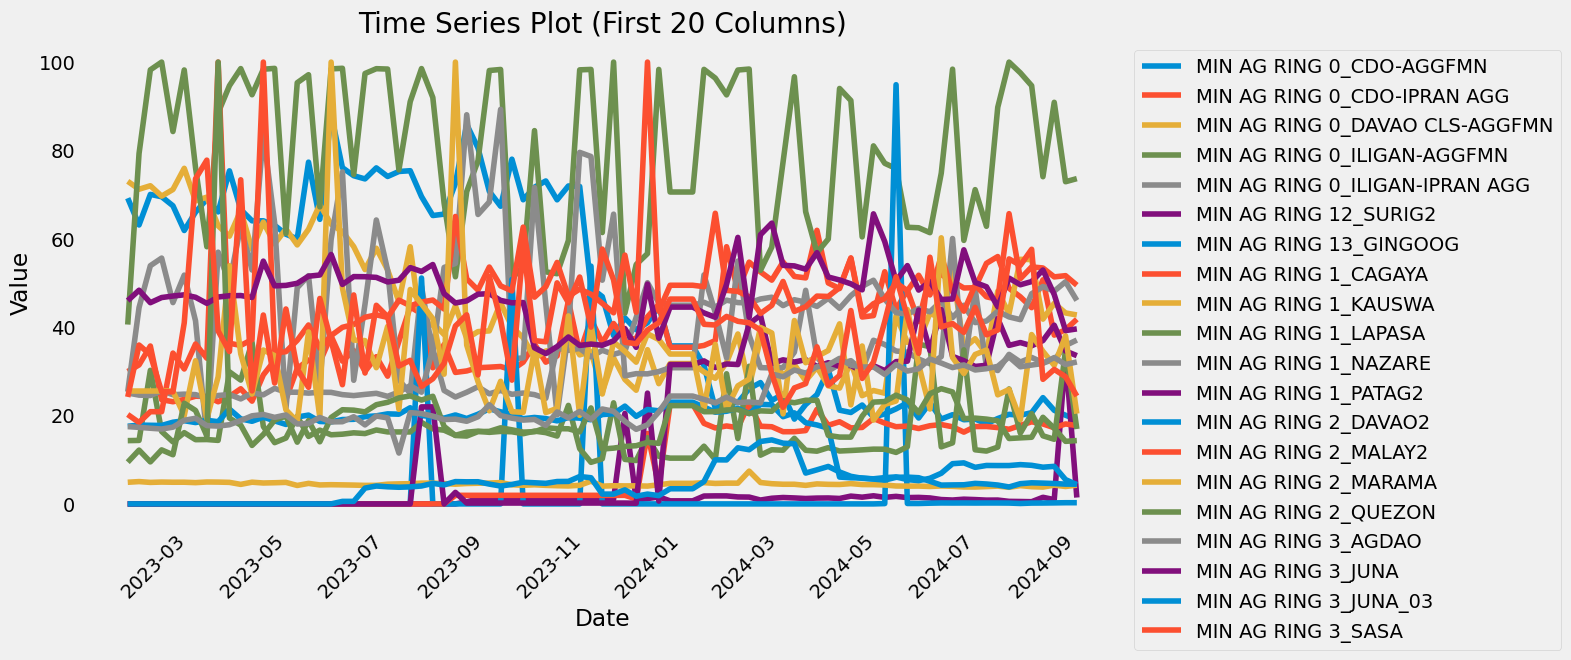

In [17]:
# Select the first 20 columns
df_subset = train.iloc[:, :20]

# Plot
plt.figure(figsize=(12, 6))
for col in df_subset.columns:
    plt.plot(df_subset.index, df_subset[col], label=col)

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Plot (First 20 Columns)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside
plt.xticks(rotation=45)
plt.grid()
plt.show()

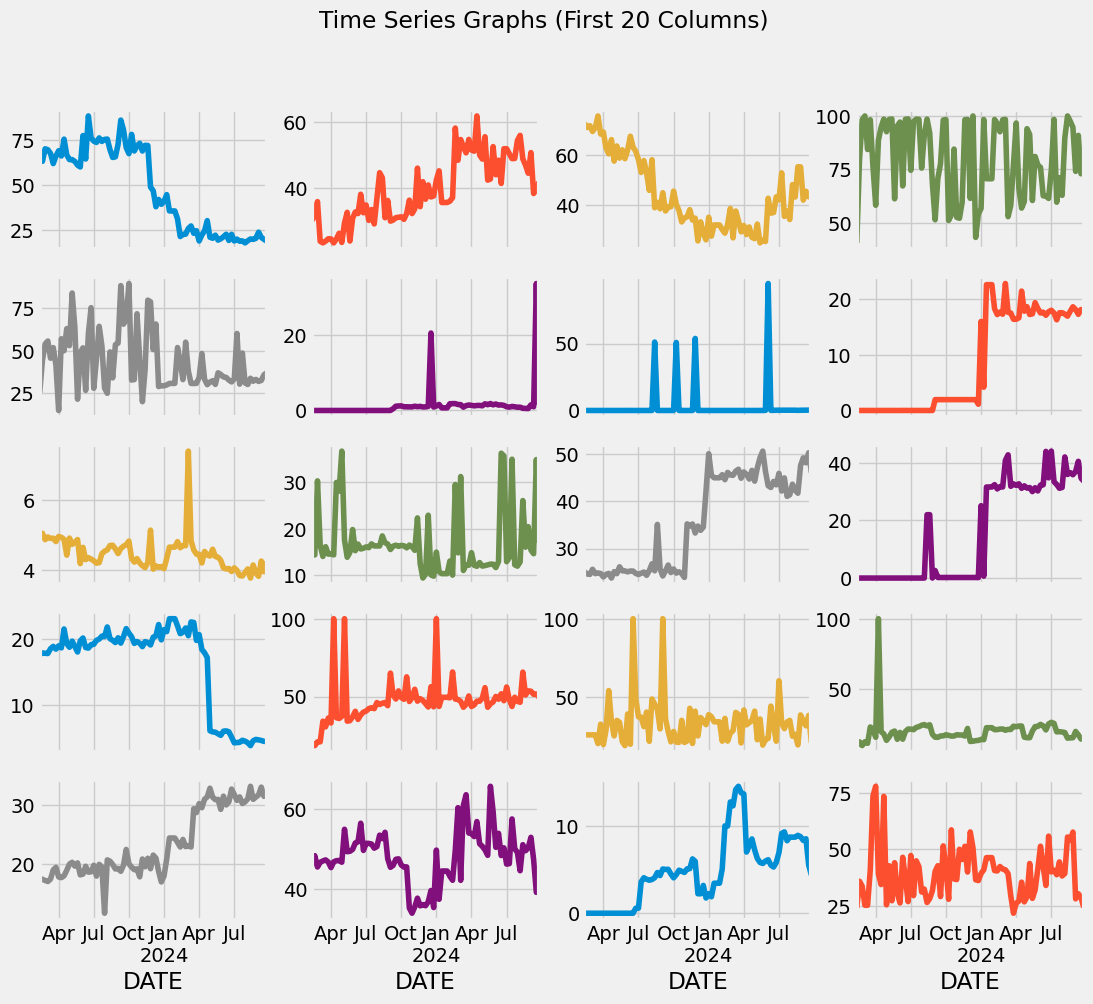

In [18]:
df_subset.plot(subplots=True, figsize=(12, 10), layout=(5, 4), sharex=True, legend=False)
plt.suptitle("Time Series Graphs (First 20 Columns)")
plt.show()


In [19]:
# Example: Concatenating train and future row-wise
val = pd.concat([test, future], ignore_index=False)
val

Short name,MIN AG RING 0_CDO-AGGFMN,MIN AG RING 0_CDO-IPRAN AGG,MIN AG RING 0_DAVAO CLS-AGGFMN,MIN AG RING 0_ILIGAN-AGGFMN,MIN AG RING 0_ILIGAN-IPRAN AGG,MIN AG RING 12_SURIG2,MIN AG RING 13_GINGOOG,MIN AG RING 1_CAGAYA,MIN AG RING 1_KAUSWA,MIN AG RING 1_LAPASA,...,VIS AG RING 8_SOONG_X2,VIS AG RING 8_TINAGO_X2,VIS AG RING 9_AGUS,VIS AG RING 9_AGUS_X8A,VIS AG RING 9_CANDUMAN,VIS AG RING 9_JSENO,VIS AG RING 9_OSMENA,SLZ AG RING 0_BACOOR-AGGFMN,SLZ AG RING 3_PALANAS,SLZ FN AG RING_NASUGBU
DATE,,,,,,,,,,,,,,,,,,,,,
2024-09-30,19.0009,59.6796,37.9522,70.2944,30.6832,1.5714,37.0984,17.5488,3.9689,12.7935,...,63.5158,24.9765,20.7915,13.6986,18.4725,14.8644,18.1906,9.67,0.04,10.03
2024-10-07,20.2206,42.4469,53.1696,97.4459,38.3137,1.5714,37.0984,17.4139,3.9221,12.8302,...,81.4610,62.3424,22.9247,13.6986,17.1831,14.4863,18.2326,9.67,0.04,10.03
2024-10-14,20.9746,58.4997,46.1007,74.2110,35.0256,1.7245,0.1622,20.7564,4.0253,16.6305,...,70.8437,16.9517,34.2959,14.8354,15.2622,13.4768,20.9067,9.67,0.04,10.03
2024-10-21,21.6888,54.4280,52.3412,77.4911,31.8409,1.5670,0.1553,16.7388,3.8777,13.0095,...,69.7147,17.8889,27.4467,16.3083,17.3642,15.4763,24.3223,9.67,0.04,10.03
2024-10-28,24.2096,53.7673,53.4381,87.4831,32.9054,1.6015,0.1965,15.4695,3.8977,12.9522,...,46.2646,59.4433,26.6964,14.9000,17.0378,13.4496,21.7745,9.67,0.04,10.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Added a calculate_mape function that calculates MAPE for non-zero actual values and returns None if there are no non-zero actual values.
#In the evaluate_model function, this function is used to calculate MAPE for both training and validation data, 
#skipping cases where actual values are zero.
def calculate_mape(actual, predicted):
    # Calculate MAPE for non-zero actual values
    non_zero_indices = actual != 0
    actual_non_zero = actual[non_zero_indices]
    predicted_non_zero = predicted[non_zero_indices]
    
    if len(actual_non_zero) == 0:
        return None  # Return None if there are no non-zero actual values
    
    mape = np.mean(np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero)) * 100
    return mape

## MODEL 1: LINEAR REGRESSION

In [21]:
# import statsmodels.api as sm

# # Create an empty dictionary to store linear regression models for each column
# linear_models = {}

# # Iterate through each column in the 'train' DataFrame
# for column in train.columns:
#     # Create a time index for the data
#     time_index = range(len(train))
    
#     # Prepare the dependent variable (y) and independent variable (X)
#     y = train[column]
#     X = sm.add_constant(time_index)  # Add a constant for the intercept term
    
#     # Fit a linear regression model
#     model = sm.OLS(y, X).fit()
    
#     # Store the linear regression model in the dictionary with the column name as the key
#     linear_models[column] = model

#     # Print the summary statistics for the current column's model
#     #print(f"Summary for {column}:\n{model.summary()}")
    
# linear_models_filename = 'AG_linear_models.pkl'
# joblib.dump(linear_models, linear_models_filename)

In [22]:
linear_models_filename = 'AG_linear_models.pkl'
linear_models = joblib.load(linear_models_filename)
linear_predictions_train = pd.DataFrame(index=train.index)
linear_predictions_val = pd.DataFrame(index=val.index)
linear_predictions_test = pd.DataFrame(index=test.index)
linear_predictions_future = pd.DataFrame(index=future.index)

def train_val_predict_linear(linear_model, column_name, train_data, validation_data, test_data, future_data):
   # Prepare the dependent variable (y) and independent variable (X) for training
    y_train = train_data[column_name]
    X_train = sm.add_constant(range(len(y_train)))  # Add a constant for the intercept
    
    # Fit a linear regression model to the training data
    linear_model = sm.OLS(y_train, X_train).fit()
    
    # Predict in-sample values for the training data
    pred_train = linear_model.predict(X_train)
    
    # Prepare the independent variable (X) for validation
    X_val = sm.add_constant(range(len(y_train), len(y_train) + len(validation_data)))
    
    # Prepare the independent variable (X) for test
    X_test = sm.add_constant(range(len(y_train), len(y_train) + len(test_data)))
    
    # Prepare the independent variable (X) for future
    X_future = sm.add_constant(range(len(y_train) + len(test_data), len(y_train) + len(test_data) +  len(future_data)))
    
    # Predict validation data
    pred_val = linear_model.predict(X_val)
    
    # Predict test data
    pred_test = linear_model.predict(X_test)
    
    # Predict future data
    pred_future = linear_model.predict(X_future)
    
    # Store the predictions and column name in the appropriate DataFrame
    linear_predictions_train[column_name] = pred_train
    linear_predictions_val[column_name] = pred_val
    linear_predictions_test[column_name] = pred_test
    linear_predictions_future[column_name] = pred_future

# Iterate through each column in the train dataset and generate predictions and plots for training, test, and OOT
for column_name, linear_model in linear_models.items():
     train_val_predict_linear(linear_model, column_name, train, val, test, future)
     # Use warnings.filterwarnings to filter out the specific warning
     warnings.filterwarnings("ignore")


linear_predictions_train = linear_predictions_train.rename(columns={old_col: old_col + '_TRAIN_FORECAST_LINEAR' for old_col in linear_predictions_train.columns})
linear_predictions_val = linear_predictions_val.rename(columns={old_col: old_col + '_VAL_FORECAST_LINEAR' for old_col in linear_predictions_val.columns})
linear_predictions_test = linear_predictions_test.rename(columns={old_col: old_col + '_TEST_FORECAST_LINEAR' for old_col in linear_predictions_test.columns})
linear_predictions_future = linear_predictions_future.rename(columns={old_col: old_col + '_FUTURE_FORECAST_LINEAR' for old_col in linear_predictions_future.columns})

In [23]:
def evaluate_regression_model(linear_model, train_data, column_name, test_data):
    # TRAINING
    # Prepare the dependent variable (y) and independent variable (X) for training
    y_train = train_data[column_name]
    X_train = sm.add_constant(range(len(y_train)))  # Add a constant for the intercept
    
    # Fit a linear regression model to the training data
    linear_model = sm.OLS(y_train, X_train).fit()
    
    # Predict training data
    pred_train = linear_model.predict(X_train)
    
    # Calculate RMSE, MAE, and MAPE for the training data
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    mae_train = mean_absolute_error(y_train, pred_train)
    mape_train = calculate_mape(train_data[column_name], pred_train)

    # TEST
    # Prepare the independent variable (X) for test
    X_test = sm.add_constant(range(len(y_train), len(y_train) + len(test_data)))
    
    # Predict test data
    pred_test = linear_model.predict(X_test)
    
    # Calculate RMSE and MAE for the test data
    rmse_test = np.sqrt(mean_squared_error(test_data[column_name], pred_test))
    mae_test = mean_absolute_error(test_data[column_name], pred_test)

    # Calculate MAPE for the test data using the calculate_mape function
    mape_test = calculate_mape(test_data[column_name], pred_test)


    # Return the evaluation metrics for training, test, and OOT data
    return rmse_train, mae_train, mape_train, rmse_test, mae_test, mape_test

# Create an empty list to store individual DataFrames
linear_scores = []

# Iterate through each column in the train dataset and evaluate the regression model for test, training, and OOT data
for column_name, linear_model in linear_models.items():
    rmse_train, mae_train, mape_train, rmse_test, mae_test, mape_test = evaluate_regression_model(linear_model, train, column_name, test)
    
    # Create a DataFrame for the current column
    linear_scores_df = pd.DataFrame({
        'RING': [column_name],
        'RMSE_TRAIN_LINEAR': [rmse_train],
        'MAE_TRAIN_LINEAR': [mae_train],
        'MAPE_TRAIN_LINEAR': [mape_train],
        'RMSE_TEST_LINEAR': [rmse_test],
        'MAE_TEST_LINEAR': [mae_test],
        'MAPE_TEST_LINEAR': [mape_test],
    })
    
    # Append the DataFrame to the list
    linear_scores.append(linear_scores_df)

# Concatenate all DataFrames into a single DataFrame
linear_scores_df = pd.concat(linear_scores, ignore_index=True)
linear_scores_df.tail()

,RING,RMSE_TRAIN_LINEAR,MAE_TRAIN_LINEAR,MAPE_TRAIN_LINEAR,RMSE_TEST_LINEAR,MAE_TEST_LINEAR,MAPE_TEST_LINEAR
308,VIS AG RING 9_JSENO,2.292700e+00,2.064920e+00,1.427941e+01,2.669400,2.528735,17.685177
309,VIS AG RING 9_OSMENA,2.144431e+00,1.732077e+00,8.735689e+00,2.375138,2.200010,11.368569
310,SLZ AG RING 0_BACOOR-AGGFMN,4.243182e-15,4.158765e-15,4.300688e-14,1.072196,0.472273,6.526520
311,SLZ AG RING 3_PALANAS,1.926200e-17,1.820439e-17,4.551098e-14,0.144992,0.031364,5.202020
312,SLZ FN AG RING_NASUGBU,3.521227e-15,3.260137e-15,3.250386e-14,1.009640,0.412727,5.497277


## MODEL 2: ARIMA

In [24]:
arima_models_filename = 'AG_arima_models.pkl'
arima_models = joblib.load(arima_models_filename)

In [25]:
# Create empty DataFrames to store training and validation predictions
arima_predictions_train = pd.DataFrame()
arima_predictions_val = pd.DataFrame()


# Define the function to train ARIMA model and get both training and validation results
def train_val_predict_arima(arima_model, column_name, train_data, validation_data):
    
    # TRAINING
    # Fit the ARIMA model to the train data for the specified column
    arima_model_fit = arima_model.fit(train_data[column_name])
    
    # Predict in-sample values for the specified column
    forecast_train, conf_int_train = arima_model_fit.predict_in_sample(return_conf_int=True, alpha=0.05)
    
    arima_forecast_train = pd.DataFrame(forecast_train, columns=[f'{column_name}_TRAIN_FORECAST_ARIMA'], index=train_data.index)
   
    # VALIDATION
    # Predict validation data and return the confidence interval
    forecast_val, conf_int_val = arima_model_fit.predict(n_periods=len(validation_data), return_conf_int=True, alpha=0.05)
    
    arima_forecast_val = pd.DataFrame(forecast_val, columns=[f'{column_name}_VAL_FORECAST_ARIMA'], index=validation_data.index)
  

    return arima_forecast_train, arima_forecast_val

# Iterate through each column in the train dataset and generate predictions for training and validation data
for column_name in train.columns:
    arima_train_df, arima_val_df = train_val_predict_arima(arima_models[column_name], column_name, train, val)
    
    # Concatenate the training and validation DataFrames for each column
    arima_predictions_train = pd.concat([arima_predictions_train, arima_train_df], axis=1)
    arima_predictions_val = pd.concat([arima_predictions_val, arima_val_df], axis=1)

In [26]:
arima_predictions_test = arima_predictions_val.loc[test.index]
# Replace "VAL" with "TEST" in column names
arima_predictions_test.columns = arima_predictions_test.columns.str.replace('_VAL_', '_TEST_')

arima_predictions_future = arima_predictions_val.loc[future.index]
# Replace "VAL" with "FUTURE" in column names
arima_predictions_future.columns = arima_predictions_future.columns.str.replace('_VAL_', '_FUTURE_')

In [27]:
# Create an empty DataFrame to store validation scores
arima_scores_df = pd.DataFrame(columns=['RING', 'RMSE_TRAIN_ARIMA', 'MAE_TRAIN_ARIMA', 'MAPE_TRAIN_ARIMA', 'RMSE_TEST_ARIMA', 'MAE_TEST_ARIMA', 'MAPE_TEST_ARIMA'])

def evaluate_arima_model(column_name, train_data, test_data, train_data_predictions, test_data_predictions):

#
    rmse_train_actualvspred = np.sqrt(mean_squared_error(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_ARIMA']))
    mae_train_actualvspred = mean_absolute_error(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_ARIMA'])
    mape_train_actualvspred = calculate_mape(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_ARIMA'])

    # TEST

    rmse_test_actualvspred = np.sqrt(mean_squared_error(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_ARIMA']))
    mae_test_actualvspred = mean_absolute_error(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_ARIMA'])
    mape_test_actualvspred = calculate_mape(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_ARIMA'])


    # Append the scores to the DataFrame
    arima_scores_df.loc[len(arima_scores_df)] = [column_name, rmse_train_actualvspred, mae_train_actualvspred, mape_train_actualvspred, 
                                                 rmse_test_actualvspred, mae_test_actualvspred, mape_test_actualvspred]

# Iterate through each column in the train dataset and calculate scores
for column_name in train.columns:
    evaluate_arima_model(column_name, train, test, arima_predictions_train, arima_predictions_test)

arima_scores_df

,RING,RMSE_TRAIN_ARIMA,MAE_TRAIN_ARIMA,MAPE_TRAIN_ARIMA,RMSE_TEST_ARIMA,MAE_TEST_ARIMA,MAPE_TEST_ARIMA
0,MIN AG RING 0_CDO-AGGFMN,11.179982,6.541110,14.738815,11.351754,10.314129,43.267256
1,MIN AG RING 0_CDO-IPRAN AGG,7.215468,5.070907,13.432516,11.826240,11.169151,19.825336
2,MIN AG RING 0_DAVAO CLS-AGGFMN,10.725657,5.925428,13.199104,24.970700,20.721292,61.876646
3,MIN AG RING 0_ILIGAN-AGGFMN,21.916325,16.880956,23.939144,21.016627,17.392520,30.081048
4,MIN AG RING 0_ILIGAN-IPRAN AGG,20.536423,15.335967,39.664541,12.201205,6.382720,14.184294
...,...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,1.890015,1.254251,8.788145,1.496037,1.273748,8.461978
309,VIS AG RING 9_OSMENA,3.186670,2.041361,10.713417,1.524337,1.114186,5.439619
310,SLZ AG RING 0_BACOOR-AGGFMN,9.670000,9.670000,100.000000,9.329351,9.275909,100.000000
311,SLZ AG RING 3_PALANAS,0.040000,0.040000,100.000000,0.158530,0.071364,100.000000


## Model 3: ARIMA with Savitzky-Golay Smoothing

### Savitzky-Golay Filter

A Savitzky–Golay filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to iMINease the precision of the data without distorting the signal tendency. The filter calculates a polynomial fit of each window based on polynomial degree and window size. 

**Window Length (window_length)**: This parameter defines the size of the sliding window or the number of data points considered at a time for smoothing or differentiation. It deterMINes the extent of the data that will be used to compute the filtered output. A larger window length results in a smoother output, but it may also reduce sensitivity to rapid changes in the data. Smaller values capture finer details but may be sensitive to noise.

**Polynomial Order (polyorder)**: This parameter specifies the order of the polynomial used for fitting the data within the sliding window. The Savitzky-Golay filter fits a polynomial to the data points within the window and uses this polynomial to compute the filtered output. The polynomial order should be a positive integer. Typically, values between 1 and 4 are used, but the choice depends on the characteristics of the data. Higher polynomial orders can capture more complex trends but may also introduce more oscillations.

**Combinations Used**
1. Window_length: 4 | Polyorder: 1
2. Window_length: 4 | Polyorder: 2
3. Window_length: 8 | Polyorder: 1
4. Window_length: 8 | Polyorder: 2

**Polyorder 1 (Linear)**: With a polyorder of 1, the Savitzky-Golay filter fits a linear polynomial (a straight line) to the data points within the sliding window (4 weeks or 8 weeks). This results in a linear smoothing or differentiation operation. It emphasizes linear trends in the data.

**Polyorder 2 (Quadratic)**: With a polyorder of 2, the filter fits a quadratic polynomial (a parabola) to the data points within the window (4 weeks or 8 weeks). This captures more complex, curved trends in the data. It can be used for smoother filtering with some curvature.


In [28]:
from scipy.signal import savgol_filter

def apply_savitzky_golay_filter(data, window_length, polyorder):
    filtered_data = pd.DataFrame(index=train.index)
    
    for column_name in data.columns:
        if np.issubdtype(data[column_name].dtype, np.number):  # Check if the column contains numeric data
            filtered_column = savgol_filter(data[column_name], window_length=window_length, polyorder=polyorder)
            filtered_data[column_name] = filtered_column
    
    return filtered_data

In [29]:
arima_smoothened_models_w5p2_filename = 'AG_arima_smoothened_models_w5p2.pkl'
arima_smoothened_models_w5p2 = joblib.load(arima_smoothened_models_w5p2_filename)

In [30]:
# Define the function to train arima_smoothened model and get both training and validation results
def train_val_predict_arima_smoothened(arima_smoothened_model, column_name, filtered_train_data, validation_data, window_length, polyorder):
    
    # TRAINING
    # Fit the arima_smoothened model to the train data for the specified column
    arima_smoothened_model_fit = arima_smoothened_model.fit(filtered_train_data[column_name])
    
    # Predict in-sample values for the specified column
    forecast_train, conf_int_train = arima_smoothened_model_fit.predict_in_sample(return_conf_int=True, alpha=0.05)
    
    arima_smoothened_forecast_train = pd.DataFrame(forecast_train, columns=[f'{column_name}_TRAIN_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}'], 
                                                   index=filtered_train_data.index)
   
    # VALIDATION
    # Predict validation data and return the confidence interval
    forecast_val, conf_int_val = arima_smoothened_model_fit.predict(n_periods=len(validation_data), return_conf_int=True, alpha=0.05)
    
    arima_smoothened_forecast_val = pd.DataFrame(forecast_val, columns=[f'{column_name}_VAL_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}'], 
                                                 index=validation_data.index)

    return arima_smoothened_forecast_train, arima_smoothened_forecast_val

In [31]:
filtered_train_w5p2 = apply_savitzky_golay_filter(train, window_length=5, polyorder=2)
arima_smoothened_w5p2_predictions_train = pd.DataFrame()
arima_smoothened_w5p2_predictions_val = pd.DataFrame()

# Iterate through each column in the train dataset and generate predictions for training and validation data
for column_name in train.columns:
    arima_smoothened_w5p2_train_df, arima_smoothened_w5p2_val_df = train_val_predict_arima_smoothened(arima_smoothened_models_w5p2[column_name], 
                                                                                                      column_name, filtered_train_w5p2, val,
                                                                                                      window_length = 5, polyorder = 2)
    
    # Concatenate the training and validation DataFrames for each column
    arima_smoothened_w5p2_predictions_train = pd.concat([arima_smoothened_w5p2_predictions_train, arima_smoothened_w5p2_train_df], axis=1)
    arima_smoothened_w5p2_predictions_val = pd.concat([arima_smoothened_w5p2_predictions_val, arima_smoothened_w5p2_val_df], axis=1)
    

In [32]:
arima_smoothened_w5p2_predictions_test = arima_smoothened_w5p2_predictions_val.loc[test.index]
# Replace "VAL" with "TEST" in column names
arima_smoothened_w5p2_predictions_test.columns = arima_smoothened_w5p2_predictions_test.columns.str.replace('_VAL_', '_TEST_')

arima_smoothened_w5p2_predictions_future = arima_smoothened_w5p2_predictions_val.loc[future.index]
# Replace "VAL" with "FUTURE" in column names
arima_smoothened_w5p2_predictions_future.columns = arima_smoothened_w5p2_predictions_future.columns.str.replace('_VAL_', '_FUTURE_')

In [33]:
# Create an empty DataFrame to store validation scores

def evaluate_arimasmoothened_model(arima_scores_df, column_name, train_data, test_data, train_data_predictions, test_data_predictions, window_length, polyorder):
    #TRAIN

    rmse_train_actualvspred = np.sqrt(mean_squared_error(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}']))
    mae_train_actualvspred = mean_absolute_error(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}'])
    mape_train_actualvspred = calculate_mape(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}'])

    # TEST

    rmse_test_actualvspred = np.sqrt(mean_squared_error(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}']))
    mae_test_actualvspred = mean_absolute_error(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}'])
    mape_test_actualvspred = calculate_mape(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_ARIMA_SMOOTHENED_W{window_length}P{polyorder}'])


    # Append the scores to the DataFrame
    arima_scores_df.loc[len(arima_scores_df)] = [column_name, rmse_train_actualvspred, mae_train_actualvspred, mape_train_actualvspred, 
                                                 rmse_test_actualvspred, mae_test_actualvspred, mape_test_actualvspred,
                                                ]


In [34]:
arima_smoothened_w5p2_scores_df = pd.DataFrame(columns=['RING', 'RMSE_TRAIN_SMOOTHENED_W5P2', 'MAE_TRAIN_ARIMA_SMOOTHENED_W5P2', 'MAPE_TRAIN_ARIMA_SMOOTHENED_W5P2', 
                                                        'RMSE_TEST_ARIMA_SMOOTHENED_W5P2', 'MAE_TEST_ARIMA_SMOOTHENED_W5P2', 'MAPE_TEST_ARIMA_SMOOTHENED_W5P2',
                                                        ])

# Iterate through each column in the train dataset and calculate scores
for column_name in train.columns:
    evaluate_arimasmoothened_model(arima_smoothened_w5p2_scores_df, column_name, train, test, arima_smoothened_w5p2_predictions_train, arima_smoothened_w5p2_predictions_test, 
                                 window_length = 5, polyorder = 2)

arima_smoothened_w5p2_scores_df

,RING,RMSE_TRAIN_SMOOTHENED_W5P2,MAE_TRAIN_ARIMA_SMOOTHENED_W5P2,MAPE_TRAIN_ARIMA_SMOOTHENED_W5P2,RMSE_TEST_ARIMA_SMOOTHENED_W5P2,MAE_TEST_ARIMA_SMOOTHENED_W5P2,MAPE_TEST_ARIMA_SMOOTHENED_W5P2
0,MIN AG RING 0_CDO-AGGFMN,9.165719,3.763939,7.698993,13.832732,12.641002,53.064171
1,MIN AG RING 0_CDO-IPRAN AGG,5.100851,3.186502,9.013698,15.084793,14.552560,25.801203
2,MIN AG RING 0_DAVAO CLS-AGGFMN,9.433230,3.870965,8.113270,9.415330,8.117798,23.394352
3,MIN AG RING 0_ILIGAN-AGGFMN,17.564344,13.676702,19.210117,23.384200,20.480768,35.327235
4,MIN AG RING 0_ILIGAN-IPRAN AGG,12.022882,8.839248,23.626027,13.550100,5.612650,11.179523
...,...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,1.457704,0.728931,5.208716,1.120911,0.982036,6.599435
309,VIS AG RING 9_OSMENA,2.019566,0.960597,5.127260,1.707116,1.152964,5.480666
310,SLZ AG RING 0_BACOOR-AGGFMN,1.048859,0.113765,1.176471,1.072196,0.472273,6.526520
311,SLZ AG RING 3_PALANAS,0.004339,0.000471,1.176471,0.144992,0.031364,5.202020


## MODEL 4: EXPONENTIAL SMOOTHING

In [35]:
# # Load the saved ETS models
# ets_models_filename = 'AG_ets_models.pkl'
# ets_models = joblib.load(ets_models_filename)

# # Create empty DataFrames to store ETS predictions
# ets_predictions_train = pd.DataFrame(index=train.index)
# ets_predictions_val = pd.DataFrame(index=val.index)
# ets_predictions_test = pd.DataFrame(index=test.index)
# ets_predictions_future = pd.DataFrame(index=future.index)

# def train_val_predict_ets(ets_model, column_name, train_data, validation_data, test_data, future_data):
#     """
#     Generates and stores predictions for train, validation, test, and future datasets using a fitted ETS model.

#     Args:
#         ets_model: Fitted ETS model for the column.
#         column_name (str): Name of the column being predicted.
#         train_data (pd.DataFrame): Training data.
#         validation_data (pd.DataFrame): Validation data.
#         test_data (pd.DataFrame): Test data.
#         future_data (pd.DataFrame): Future data (for out-of-sample forecasting).
#     """

#     # Predict in-sample values for the training data
#     pred_train = ets_model.fittedvalues

#     # Predict validation data
#     pred_val = ets_model.forecast(steps=len(validation_data)+1)

#     # Predict test data
#     pred_test = ets_model.forecast(steps=len(test_data)+1)

#     # Predict future data
#     pred_future = ets_model.forecast(steps=len(future_data)+1)

#     # Store the predictions and column name in the appropriate DataFrame
#     ets_predictions_train[column_name] = pred_train
#     ets_predictions_val[column_name] = pred_val
#     ets_predictions_test[column_name] = pred_test
#     ets_predictions_future[column_name] = pred_future

# # Iterate through each column and its corresponding ETS model to generate predictions
# for column_name, ets_model in ets_models.items():
#     train_val_predict_ets(ets_model, column_name, train, val, test, future)
#     # Use warnings.filterwarnings to filter out specific warnings if needed for ETS models
#     warnings.filterwarnings("ignore") # Add specific warnings you might want to ignore for ETS if any


# # Rename columns to indicate ETS predictions
# ets_predictions_train = ets_predictions_train.rename(columns={old_col: old_col + '_TRAIN_FORECAST_ETS' for old_col in ets_predictions_train.columns})
# ets_predictions_val = ets_predictions_val.rename(columns={old_col: old_col + '_VAL_FORECAST_ETS' for old_col in ets_predictions_val.columns})
# ets_predictions_test = ets_predictions_test.rename(columns={old_col: old_col + '_TEST_FORECAST_ETS' for old_col in ets_predictions_test.columns})
# ets_predictions_future = ets_predictions_future.rename(columns={old_col: old_col + '_FUTURE_FORECAST_ETS' for old_col in ets_predictions_future.columns})

In [36]:
# Load the saved ETS models
ets_models_filename = 'AG_ets_models.pkl'
ets_models = joblib.load(ets_models_filename)

# Create empty DataFrames to store training and validation predictions
ets_predictions_train = pd.DataFrame()
ets_predictions_val = pd.DataFrame()


# Define the function to train ETS model and get both training and validation results
def train_val_predict_ets(ets_model, column_name, train_data, validation_data):

    # TRAINING
    # ETS models already fitted on the entire train data during model selection, fittedvalues are in-sample predictions.
    forecast_train = ets_model.fittedvalues

    ets_forecast_train = pd.DataFrame(forecast_train, columns=[f'{column_name}_TRAIN_FORECAST_ETS'], index=train_data.index)

    # VALIDATION
    # Predict validation data
    start = len(train_data)
    end = start + len(validation_data) 
    forecast_val = ets_model.predict(start=start, end=end)

    ets_forecast_val = pd.DataFrame(forecast_val, columns=[f'{column_name}_VAL_FORECAST_ETS'], index=validation_data.index)

    return ets_forecast_train, ets_forecast_val

# Iterate through each column in the train dataset and generate predictions for training and validation data
for column_name in train.columns:
    ets_train_df, ets_val_df = train_val_predict_ets(ets_models[column_name], column_name, train[column_name], val[column_name])

    # Concatenate the training and validation DataFrames for each column
    ets_predictions_train = pd.concat([ets_predictions_train, ets_train_df], axis=1)
    ets_predictions_val = pd.concat([ets_predictions_val, ets_val_df], axis=1)



In [37]:
ets_predictions_val

,MIN AG RING 0_CDO-AGGFMN_VAL_FORECAST_ETS,MIN AG RING 0_CDO-IPRAN AGG_VAL_FORECAST_ETS,MIN AG RING 0_DAVAO CLS-AGGFMN_VAL_FORECAST_ETS,MIN AG RING 0_ILIGAN-AGGFMN_VAL_FORECAST_ETS,MIN AG RING 0_ILIGAN-IPRAN AGG_VAL_FORECAST_ETS,MIN AG RING 12_SURIG2_VAL_FORECAST_ETS,MIN AG RING 13_GINGOOG_VAL_FORECAST_ETS,MIN AG RING 1_CAGAYA_VAL_FORECAST_ETS,MIN AG RING 1_KAUSWA_VAL_FORECAST_ETS,MIN AG RING 1_LAPASA_VAL_FORECAST_ETS,...,VIS AG RING 8_SOONG_X2_VAL_FORECAST_ETS,VIS AG RING 8_TINAGO_X2_VAL_FORECAST_ETS,VIS AG RING 9_AGUS_VAL_FORECAST_ETS,VIS AG RING 9_AGUS_X8A_VAL_FORECAST_ETS,VIS AG RING 9_CANDUMAN_VAL_FORECAST_ETS,VIS AG RING 9_JSENO_VAL_FORECAST_ETS,VIS AG RING 9_OSMENA_VAL_FORECAST_ETS,SLZ AG RING 0_BACOOR-AGGFMN_VAL_FORECAST_ETS,SLZ AG RING 3_PALANAS_VAL_FORECAST_ETS,SLZ FN AG RING_NASUGBU_VAL_FORECAST_ETS
DATE,,,,,,,,,,,,,,,,,,,,,
2024-09-30,19.558545,41.894276,43.81984,79.632901,29.335274,4.155803,0.002176,17.795457,4.046084,15.387839,...,64.956089,39.034331,21.002684,55.789268,20.347489,14.05932,19.062937,9.67,0.04,10.03
2024-10-07,20.347727,41.894276,43.81984,79.632901,34.316975,8.282637,1.073213,17.795457,4.000202,19.278864,...,58.818758,47.849864,21.002684,10.726507,20.208901,14.05932,19.062937,9.67,0.04,10.03
2024-10-14,20.356960,41.894276,43.81984,79.632901,27.908047,8.027661,1.350976,17.795457,4.400602,20.313508,...,67.821434,28.346356,21.002684,30.659020,20.995089,14.05932,19.062937,9.67,0.04,10.03
2024-10-21,20.059993,41.894276,43.81984,79.632901,31.452739,9.189375,1.761602,17.795457,4.208278,13.257320,...,76.166401,23.587958,21.002684,14.067400,19.634964,14.05932,19.062937,9.67,0.04,10.03
2024-10-28,19.460412,41.894276,43.81984,79.632901,35.741455,8.082073,0.118668,17.795457,4.243086,15.399349,...,60.669744,38.674597,21.002684,14.149000,20.394091,14.05932,19.062937,9.67,0.04,10.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-01-31,-16.778160,41.894276,43.81984,79.632901,-1.192469,52.782306,4.532443,17.795457,3.428257,20.966629,...,92.601315,54.527185,21.002684,-11.586008,55.821219,14.05932,19.062937,9.67,0.04,10.03
2028-02-07,-16.987479,41.894276,43.81984,79.632901,-1.377428,51.074144,3.910755,17.795457,3.385615,13.683491,...,78.158199,34.796303,21.002684,-11.696539,53.664256,14.05932,19.062937,9.67,0.04,10.03
2028-02-14,-17.628581,41.894276,43.81984,79.632901,-1.325080,51.460605,0.104113,17.795457,3.378691,15.894285,...,91.048048,66.368619,21.002684,-49.941532,55.581459,14.05932,19.062937,9.67,0.04,10.03


In [38]:
ets_predictions_test = ets_predictions_val.loc[test.index]
# Replace "VAL" with "TEST" in column names
ets_predictions_test.columns = ets_predictions_test.columns.str.replace('_VAL_', '_TEST_')

ets_predictions_future = ets_predictions_val.loc[future.index]
# Replace "VAL" with "FUTURE" in column names
ets_predictions_future.columns = ets_predictions_future.columns.str.replace('_VAL_', '_FUTURE_')

In [39]:
ets_predictions_future

,MIN AG RING 0_CDO-AGGFMN_FUTURE_FORECAST_ETS,MIN AG RING 0_CDO-IPRAN AGG_FUTURE_FORECAST_ETS,MIN AG RING 0_DAVAO CLS-AGGFMN_FUTURE_FORECAST_ETS,MIN AG RING 0_ILIGAN-AGGFMN_FUTURE_FORECAST_ETS,MIN AG RING 0_ILIGAN-IPRAN AGG_FUTURE_FORECAST_ETS,MIN AG RING 12_SURIG2_FUTURE_FORECAST_ETS,MIN AG RING 13_GINGOOG_FUTURE_FORECAST_ETS,MIN AG RING 1_CAGAYA_FUTURE_FORECAST_ETS,MIN AG RING 1_KAUSWA_FUTURE_FORECAST_ETS,MIN AG RING 1_LAPASA_FUTURE_FORECAST_ETS,...,VIS AG RING 8_SOONG_X2_FUTURE_FORECAST_ETS,VIS AG RING 8_TINAGO_X2_FUTURE_FORECAST_ETS,VIS AG RING 9_AGUS_FUTURE_FORECAST_ETS,VIS AG RING 9_AGUS_X8A_FUTURE_FORECAST_ETS,VIS AG RING 9_CANDUMAN_FUTURE_FORECAST_ETS,VIS AG RING 9_JSENO_FUTURE_FORECAST_ETS,VIS AG RING 9_OSMENA_FUTURE_FORECAST_ETS,SLZ AG RING 0_BACOOR-AGGFMN_FUTURE_FORECAST_ETS,SLZ AG RING 3_PALANAS_FUTURE_FORECAST_ETS,SLZ FN AG RING_NASUGBU_FUTURE_FORECAST_ETS
DATE,,,,,,,,,,,,,,,,,,,,,
2025-03-10,14.336135,41.894276,43.81984,79.632901,30.314563,10.313916,2.016179,17.795457,3.962533,13.306875,...,58.782863,36.287523,21.002684,9.949764,23.976105,14.05932,19.062937,9.67,0.04,10.03
2025-03-17,14.487573,41.894276,43.81984,79.632901,25.154317,10.606458,0.003175,17.795457,3.955076,15.456900,...,68.514083,26.870124,21.002684,41.371431,22.782652,14.05932,19.062937,9.67,0.04,10.03
2025-03-24,15.014528,41.894276,43.81984,79.632901,29.396791,20.358004,0.003999,17.795457,3.910142,19.365372,...,62.033242,37.798058,21.002684,7.924239,23.850096,14.05932,19.062937,9.67,0.04,10.03
2025-03-31,14.962428,41.894276,43.81984,79.632901,23.882694,19.061056,0.002707,17.795457,4.301434,20.404641,...,71.519499,40.755055,21.002684,22.561297,26.362184,14.05932,19.062937,9.67,0.04,10.03
2025-04-07,14.684806,41.894276,43.81984,79.632901,26.888683,21.135338,1.332635,17.795457,4.113354,13.316786,...,80.310073,49.955627,21.002684,10.310545,26.115477,14.05932,19.062937,9.67,0.04,10.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-01-31,-16.778160,41.894276,43.81984,79.632901,-1.192469,52.782306,4.532443,17.795457,3.428257,20.966629,...,92.601315,54.527185,21.002684,-11.586008,55.821219,14.05932,19.062937,9.67,0.04,10.03
2028-02-07,-16.987479,41.894276,43.81984,79.632901,-1.377428,51.074144,3.910755,17.795457,3.385615,13.683491,...,78.158199,34.796303,21.002684,-11.696539,53.664256,14.05932,19.062937,9.67,0.04,10.03
2028-02-14,-17.628581,41.894276,43.81984,79.632901,-1.325080,51.460605,0.104113,17.795457,3.378691,15.894285,...,91.048048,66.368619,21.002684,-49.941532,55.581459,14.05932,19.062937,9.67,0.04,10.03


In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create an empty DataFrame to store validation scores
ets_scores_df = pd.DataFrame(columns=['RING', 'RMSE_TRAIN_ETS', 'MAE_TRAIN_ETS', 'MAPE_TRAIN_ETS', 
                                       'RMSE_TEST_ETS', 'MAE_TEST_ETS', 'MAPE_TEST_ETS'])

# def calculate_mape(y_true, y_pred):
#     mask = y_true != 0  # Avoid division by zero
#     return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

def evaluate_ets_model(column_name, train_data, test_data, train_data_predictions, test_data_predictions):
    # Drop NaN values from actuals and predictions before computing metrics
    train_actual = train_data[column_name].dropna()
    train_pred = train_data_predictions[f'{column_name}_TRAIN_FORECAST_ETS'].dropna()

    test_actual = test_data[column_name].dropna()
    test_pred = test_data_predictions[f'{column_name}_TEST_FORECAST_ETS'].dropna()

    # Ensure non-empty arrays for metric calculation
    if len(train_actual) == 0 or len(train_pred) == 0:
        rmse_train_actualvspred = mae_train_actualvspred = mape_train_actualvspred = np.nan
    else:
        rmse_train_actualvspred = np.sqrt(mean_squared_error(train_actual, train_pred))
        mae_train_actualvspred = mean_absolute_error(train_actual, train_pred)
        mape_train_actualvspred = calculate_mape(train_actual, train_pred)

    if len(test_actual) == 0 or len(test_pred) == 0:
        rmse_test_actualvspred = mae_test_actualvspred = mape_test_actualvspred = np.nan
    else:
        rmse_test_actualvspred = np.sqrt(mean_squared_error(test_actual, test_pred))
        mae_test_actualvspred = mean_absolute_error(test_actual, test_pred)
        mape_test_actualvspred = calculate_mape(test_actual, test_pred)

    # Append the scores to the DataFrame
    ets_scores_df.loc[len(ets_scores_df)] = [column_name, rmse_train_actualvspred, mae_train_actualvspred, mape_train_actualvspred, 
                                             rmse_test_actualvspred, mae_test_actualvspred, mape_test_actualvspred]

# Iterate through each column in the train dataset and calculate scores
for column_name in train.columns:
    evaluate_ets_model(column_name, train, test, ets_predictions_train, ets_predictions_test)

ets_scores_df


,RING,RMSE_TRAIN_ETS,MAE_TRAIN_ETS,MAPE_TRAIN_ETS,RMSE_TEST_ETS,MAE_TEST_ETS,MAPE_TEST_ETS
0,MIN AG RING 0_CDO-AGGFMN,5.531848e+00,3.699989e+00,8.639854e+00,6.203165,5.414837,22.484800
1,MIN AG RING 0_CDO-IPRAN AGG,5.307972e+00,4.000608e+00,1.027511e+01,14.196699,13.633788,24.120686
2,MIN AG RING 0_DAVAO CLS-AGGFMN,5.560551e+00,4.308631e+00,1.062972e+01,9.590366,8.299183,23.692504
3,MIN AG RING 0_ILIGAN-AGGFMN,1.746638e+01,1.569436e+01,2.199627e+01,21.713350,19.135273,33.520914
4,MIN AG RING 0_ILIGAN-IPRAN AGG,1.612820e+01,1.167441e+01,3.308890e+01,14.487231,6.511324,13.381263
...,...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,1.396974e+00,9.928636e-01,6.641849e+00,1.064145,0.915137,6.164544
309,VIS AG RING 9_OSMENA,2.023050e+00,1.446859e+00,7.181405e+00,1.814412,1.173259,5.516656
310,SLZ AG RING 0_BACOOR-AGGFMN,7.209162e-16,1.253899e-16,1.296690e-15,1.072196,0.472273,6.526520
311,SLZ AG RING 3_PALANAS,1.367218e-17,1.355125e-17,3.387813e-14,0.144992,0.031364,5.202020


## MODEL 5 PROPHET

In [41]:
import joblib
import pandas as pd

# Load the saved Prophet models
prophet_models_filename = 'AG_prophet_models.pkl'
prophet_models = joblib.load(prophet_models_filename)

# Create empty DataFrames to store training and validation predictions for Prophet
prophet_predictions_train = pd.DataFrame()
prophet_predictions_val = pd.DataFrame()

# Define the function to train Prophet model and get both training and validation results
def train_val_predict_prophet(prophet_model, column_name, train_data, validation_data):

    # TRAINING
    # Prepare future dataframe for training period (in-sample predictions)
    future_train = prophet_model.make_future_dataframe(periods=len(train_data), freq=train_data.index.freq) # Use train_data.index.freq to infer frequency

    # Predict on the training future dataframe
    forecast_train = prophet_model.predict(future_train)

    # Merge the forecast with the original train data index to align predictions
    prophet_forecast_train = pd.DataFrame(index=train_data.index)
    prophet_forecast_train[f'{column_name}_TRAIN_FORECAST_PROPHET'] = forecast_train['yhat'].iloc[:len(train_data)].values # Take first len(train_data) yhat values


    # VALIDATION
    # Prepare future dataframe for validation period
    future_val = prophet_model.make_future_dataframe(periods=len(validation_data), freq=validation_data.index.freq) # Use validation_data.index.freq to infer frequency

    # Predict on the validation future dataframe
    forecast_val = prophet_model.predict(future_val)

    # Take the forecast for the validation period (last len(validation_data) periods)
    prophet_forecast_val = pd.DataFrame(index=validation_data.index) # Use validation_data index
    prophet_forecast_val[f'{column_name}_VAL_FORECAST_PROPHET'] = forecast_val['yhat'].iloc[-len(validation_data):].values # Take last len(validation_data) yhat values


    return prophet_forecast_train, prophet_forecast_val

# Iterate through each column in the train dataset and generate predictions for training and validation data
for column_name in train.columns:
    prophet_train_df, prophet_val_df = train_val_predict_prophet(prophet_models[column_name], column_name, train, val)

    # Concatenate the training and validation DataFrames for each column
    prophet_predictions_train = pd.concat([prophet_predictions_train, prophet_train_df], axis=1)
    prophet_predictions_val = pd.concat([prophet_predictions_val, prophet_val_df], axis=1)


In [42]:
prophet_predictions_test = prophet_predictions_val.loc[test.index]
# Replace "VAL" with "TEST" in column names
prophet_predictions_test.columns = prophet_predictions_test.columns.str.replace('_VAL_', '_TEST_')

prophet_predictions_future = prophet_predictions_val.loc[future.index]
# Replace "VAL" with "FUTURE" in column names
prophet_predictions_future.columns = prophet_predictions_future.columns.str.replace('_VAL_', '_FUTURE_')

In [43]:
# Create an empty DataFrame to store validation scores
prophet_scores_df = pd.DataFrame(columns=['RING', 'RMSE_TRAIN_PROPHET', 'MAE_TRAIN_PROPHET', 'MAPE_TRAIN_PROPHET', 'RMSE_TEST_PROPHET', 'MAE_TEST_PROPHET', 'MAPE_TEST_PROPHET'])

def evaluate_prophet_model(column_name, train_data, test_data, train_data_predictions, test_data_predictions):

#
    rmse_train_actualvspred = np.sqrt(mean_squared_error(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_PROPHET']))
    mae_train_actualvspred = mean_absolute_error(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_PROPHET'])
    mape_train_actualvspred = calculate_mape(train_data[column_name], train_data_predictions[f'{column_name}_TRAIN_FORECAST_PROPHET'])

    # TEST

    rmse_test_actualvspred = np.sqrt(mean_squared_error(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_PROPHET']))
    mae_test_actualvspred = mean_absolute_error(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_PROPHET'])
    mape_test_actualvspred = calculate_mape(test_data[column_name], test_data_predictions[f'{column_name}_TEST_FORECAST_PROPHET'])


    # Append the scores to the DataFrame
    prophet_scores_df.loc[len(prophet_scores_df)] = [column_name, rmse_train_actualvspred, mae_train_actualvspred, mape_train_actualvspred, 
                                                 rmse_test_actualvspred, mae_test_actualvspred, mape_test_actualvspred]

# Iterate through each column in the train dataset and calculate scores
for column_name in train.columns:
    evaluate_prophet_model(column_name, train, test, prophet_predictions_train, prophet_predictions_test)

prophet_scores_df

,RING,RMSE_TRAIN_PROPHET,MAE_TRAIN_PROPHET,MAPE_TRAIN_PROPHET,RMSE_TEST_PROPHET,MAE_TEST_PROPHET,MAPE_TEST_PROPHET
0,MIN AG RING 0_CDO-AGGFMN,11.236784,9.382385,22.122391,21.524955,20.420355,86.598937
1,MIN AG RING 0_CDO-IPRAN AGG,5.979409,4.931193,12.795808,4.461053,3.404736,6.340850
2,MIN AG RING 0_DAVAO CLS-AGGFMN,5.244373,4.027811,10.235801,14.592113,12.216162,36.376106
3,MIN AG RING 0_ILIGAN-AGGFMN,17.243628,15.123322,21.326229,19.098037,16.571956,27.706593
4,MIN AG RING 0_ILIGAN-IPRAN AGG,15.355797,11.338813,29.361180,13.593474,6.482883,13.656764
...,...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,1.358285,1.080054,7.518064,1.621735,1.423426,9.503679
309,VIS AG RING 9_OSMENA,2.029641,1.594951,8.009826,1.937536,1.708570,8.702003
310,SLZ AG RING 0_BACOOR-AGGFMN,0.000000,0.000000,0.000000,1.072196,0.472273,6.526520
311,SLZ AG RING 3_PALANAS,0.000000,0.000000,0.000000,0.144992,0.031364,5.202020


## MODEL MAPE SCORES COMPARISON

In [44]:
score_dfs = [linear_scores_df, arima_scores_df, arima_smoothened_w5p2_scores_df,ets_scores_df,prophet_scores_df]

# Initialize comparison_df with the "RING" column from the first DataFrame (linear_scores_df)
comparison_df = score_dfs[0][["RING"]]

# Initialize an empty list to store the selected "MAPE" columns
selected_columns_list = []

# Loop through each DataFrame and select columns starting with "MAPE"
for score_df in score_dfs:
    selected_columns = [col for col in score_df.columns if col.startswith("MAPE")]
    
    # Append the selected columns to the list
    selected_columns_list.append(score_df[selected_columns])

# Concatenate the "MAPE" columns to the comparison_df along the columns axis
comparison_df = pd.concat([comparison_df] + selected_columns_list, axis=1)
comparison_df

,RING,MAPE_TRAIN_LINEAR,MAPE_TEST_LINEAR,MAPE_TRAIN_ARIMA,MAPE_TEST_ARIMA,MAPE_TRAIN_ARIMA_SMOOTHENED_W5P2,MAPE_TEST_ARIMA_SMOOTHENED_W5P2,MAPE_TRAIN_ETS,MAPE_TEST_ETS,MAPE_TRAIN_PROPHET,MAPE_TEST_PROPHET
0,MIN AG RING 0_CDO-AGGFMN,2.218182e+01,85.657735,14.738815,43.267256,7.698993,53.064171,8.639854e+00,22.484800,22.122391,86.598937
1,MIN AG RING 0_CDO-IPRAN AGG,1.279744e+01,6.363897,13.432516,19.825336,9.013698,25.801203,1.027511e+01,24.120686,12.795808,6.340850
2,MIN AG RING 0_DAVAO CLS-AGGFMN,2.408889e+01,40.187442,13.199104,61.876646,8.113270,23.394352,1.062972e+01,23.692504,10.235801,36.376106
3,MIN AG RING 0_ILIGAN-AGGFMN,2.132570e+01,27.703072,23.939144,30.081048,19.210117,35.327235,2.199627e+01,33.520914,21.326229,27.706593
4,MIN AG RING 0_ILIGAN-IPRAN AGG,2.936797e+01,13.618331,39.664541,14.184294,23.626027,11.179523,3.308890e+01,13.381263,29.361180,13.656764
...,...,...,...,...,...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,1.427941e+01,17.685177,8.788145,8.461978,5.208716,6.599435,6.641849e+00,6.164544,7.518064,9.503679
309,VIS AG RING 9_OSMENA,8.735689e+00,11.368569,10.713417,5.439619,5.127260,5.480666,7.181405e+00,5.516656,8.009826,8.702003
310,SLZ AG RING 0_BACOOR-AGGFMN,4.300688e-14,6.526520,100.000000,100.000000,1.176471,6.526520,1.296690e-15,6.526520,0.000000,6.526520
311,SLZ AG RING 3_PALANAS,4.551098e-14,5.202020,100.000000,100.000000,1.176471,5.202020,3.387813e-14,5.202020,0.000000,5.202020


In [45]:
# Compute the mean per column of the "MAPE_TRAIN" columns
mean_mape_train = comparison_df.filter(like="MAPE_TRAIN").mean()

# Print or use the mean values as needed
print(mean_mape_train)

MAPE_TRAIN_LINEAR                   67571.225906
MAPE_TRAIN_ARIMA                    17332.456458
MAPE_TRAIN_ARIMA_SMOOTHENED_W5P2    14238.464291
MAPE_TRAIN_ETS                      30449.308806
MAPE_TRAIN_PROPHET                  65634.555209
dtype: float64


In [46]:
# Compute the mean per column of the "MAPE_TEST" columns
mean_mape_test = comparison_df.filter(like="MAPE_TEST").mean()

# Print or use the mean values as needed
print(mean_mape_test)

MAPE_TEST_LINEAR                   17936.375046
MAPE_TEST_ARIMA                    28582.477289
MAPE_TEST_ARIMA_SMOOTHENED_W5P2    25990.222062
MAPE_TEST_ETS                       7850.464465
MAPE_TEST_PROPHET                  10560.641280
dtype: float64


### Model Selection for each Ring

#### Getting the top models for TEST based on lowest MAPE per ring

In [47]:
# Initialize comparison_df with the "RING" column from the first DataFrame (linear_scores_df)
comparison_df_test = score_dfs[0][["RING"]]

# Initialize an empty list to store the selected "MAPE_TEST" columns
selected_columns_list_1 = []

# Loop through each DataFrame and select columns starting with "MAPE_TEST"
for score_df in score_dfs:
    selected_columns_1 = [col for col in score_df.columns if col.startswith("MAPE_TEST")]
    
    # Append the selected columns to the list
    selected_columns_list_1.append(score_df[selected_columns_1])

# Concatenate the "MAPE" columns to the comparison_df along the columns axis
comparison_df_test = pd.concat([comparison_df_test] + selected_columns_list_1, axis=1)

In [48]:
nan_rows_test = comparison_df_test[comparison_df_test[['MAPE_TEST_LINEAR', 'MAPE_TEST_ARIMA', 'MAPE_TEST_ARIMA_SMOOTHENED_W5P2','MAPE_TEST_ETS','MAPE_TEST_PROPHET']].isna().all(axis=1)]
nan_rows_test

,RING,MAPE_TEST_LINEAR,MAPE_TEST_ARIMA,MAPE_TEST_ARIMA_SMOOTHENED_W5P2,MAPE_TEST_ETS,MAPE_TEST_PROPHET


In [49]:
comparison_df_test = comparison_df_test.drop(nan_rows_test.index)
comparison_df_test

,RING,MAPE_TEST_LINEAR,MAPE_TEST_ARIMA,MAPE_TEST_ARIMA_SMOOTHENED_W5P2,MAPE_TEST_ETS,MAPE_TEST_PROPHET
0,MIN AG RING 0_CDO-AGGFMN,85.657735,43.267256,53.064171,22.484800,86.598937
1,MIN AG RING 0_CDO-IPRAN AGG,6.363897,19.825336,25.801203,24.120686,6.340850
2,MIN AG RING 0_DAVAO CLS-AGGFMN,40.187442,61.876646,23.394352,23.692504,36.376106
3,MIN AG RING 0_ILIGAN-AGGFMN,27.703072,30.081048,35.327235,33.520914,27.706593
4,MIN AG RING 0_ILIGAN-IPRAN AGG,13.618331,14.184294,11.179523,13.381263,13.656764
...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,17.685177,8.461978,6.599435,6.164544,9.503679
309,VIS AG RING 9_OSMENA,11.368569,5.439619,5.480666,5.516656,8.702003
310,SLZ AG RING 0_BACOOR-AGGFMN,6.526520,100.000000,6.526520,6.526520,6.526520
311,SLZ AG RING 3_PALANAS,5.202020,100.000000,5.202020,5.202020,5.202020


In [50]:
# Create a function to get the sorted column names for each row
def get_top_models(row):
    sorted_columns = sorted(row.index[1:], key=lambda x: row[x])
    return sorted_columns[:6]

# Apply the function to each row to get the top models
comparison_df_test['TOP_MODELS'] = comparison_df_test.apply(get_top_models, axis=1)

# Create separate columns for each of the top models and remove the 'MAPE_TEST' prefix
for i in range(1, 7):
    comparison_df_test[f'TOP_{i}_MODEL_TEST'] = comparison_df_test['TOP_MODELS'].apply(lambda x: x[i - 1].replace('MAPE_TEST_', '') if len(x) >= i else '')

# Drop the 'Top Models' column if  no longer need 
comparison_df_test.drop(columns=['TOP_MODELS'], inplace=True)

# Create a list of the top model column names
top_model_test_columns = ['TOP_1_MODEL_TEST', 'TOP_2_MODEL_TEST', 'TOP_3_MODEL_TEST','TOP_4_MODEL_TEST', 'TOP_5_MODEL_TEST']




# Create a function to get the corresponding MAPE values for each top model per row
def corresponding_mape_top_model(row, top_model_col):
    model_names = row[top_model_col].split(', ')
    mape_values = [row[f'MAPE_TEST_{model}'] for model in model_names if model != '']
    return sum(mape_values) / len(mape_values) 

# Get the corresponding MAPE_TEST for each top model column
for top_model_col in top_model_test_columns:
    comparison_df_test[f'{top_model_col}_MAPE'] = comparison_df_test.apply(lambda row: corresponding_mape_top_model(row, top_model_col), axis=1)

# Reorder the DataFrame
# Reorder the DataFrame
comparison_df_test = comparison_df_test[['RING', 'MAPE_TEST_LINEAR', 'MAPE_TEST_ARIMA', 'MAPE_TEST_ARIMA_SMOOTHENED_W5P2','MAPE_TEST_ETS', 'MAPE_TEST_PROPHET',
                                       'TOP_1_MODEL_TEST', 'TOP_2_MODEL_TEST', 'TOP_3_MODEL_TEST','TOP_4_MODEL_TEST', 'TOP_5_MODEL_TEST',
                                       'TOP_1_MODEL_TEST_MAPE', 'TOP_2_MODEL_TEST_MAPE', 'TOP_3_MODEL_TEST_MAPE','TOP_4_MODEL_TEST_MAPE', 'TOP_5_MODEL_TEST_MAPE']]

comparison_df_test


,RING,MAPE_TEST_LINEAR,MAPE_TEST_ARIMA,MAPE_TEST_ARIMA_SMOOTHENED_W5P2,MAPE_TEST_ETS,MAPE_TEST_PROPHET,TOP_1_MODEL_TEST,TOP_2_MODEL_TEST,TOP_3_MODEL_TEST,TOP_4_MODEL_TEST,TOP_5_MODEL_TEST,TOP_1_MODEL_TEST_MAPE,TOP_2_MODEL_TEST_MAPE,TOP_3_MODEL_TEST_MAPE,TOP_4_MODEL_TEST_MAPE,TOP_5_MODEL_TEST_MAPE
0,MIN AG RING 0_CDO-AGGFMN,85.657735,43.267256,53.064171,22.484800,86.598937,ETS,ARIMA,ARIMA_SMOOTHENED_W5P2,LINEAR,PROPHET,22.484800,43.267256,53.064171,85.657735,86.598937
1,MIN AG RING 0_CDO-IPRAN AGG,6.363897,19.825336,25.801203,24.120686,6.340850,PROPHET,LINEAR,ARIMA,ETS,ARIMA_SMOOTHENED_W5P2,6.340850,6.363897,19.825336,24.120686,25.801203
2,MIN AG RING 0_DAVAO CLS-AGGFMN,40.187442,61.876646,23.394352,23.692504,36.376106,ARIMA_SMOOTHENED_W5P2,ETS,PROPHET,LINEAR,ARIMA,23.394352,23.692504,36.376106,40.187442,61.876646
3,MIN AG RING 0_ILIGAN-AGGFMN,27.703072,30.081048,35.327235,33.520914,27.706593,LINEAR,PROPHET,ARIMA,ETS,ARIMA_SMOOTHENED_W5P2,27.703072,27.706593,30.081048,33.520914,35.327235
4,MIN AG RING 0_ILIGAN-IPRAN AGG,13.618331,14.184294,11.179523,13.381263,13.656764,ARIMA_SMOOTHENED_W5P2,ETS,LINEAR,PROPHET,ARIMA,11.179523,13.381263,13.618331,13.656764,14.184294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,17.685177,8.461978,6.599435,6.164544,9.503679,ETS,ARIMA_SMOOTHENED_W5P2,ARIMA,PROPHET,LINEAR,6.164544,6.599435,8.461978,9.503679,17.685177
309,VIS AG RING 9_OSMENA,11.368569,5.439619,5.480666,5.516656,8.702003,ARIMA,ARIMA_SMOOTHENED_W5P2,ETS,PROPHET,LINEAR,5.439619,5.480666,5.516656,8.702003,11.368569
310,SLZ AG RING 0_BACOOR-AGGFMN,6.526520,100.000000,6.526520,6.526520,6.526520,ARIMA_SMOOTHENED_W5P2,ETS,PROPHET,LINEAR,ARIMA,6.526520,6.526520,6.526520,6.526520,100.000000
311,SLZ AG RING 3_PALANAS,5.202020,100.000000,5.202020,5.202020,5.202020,PROPHET,LINEAR,ARIMA_SMOOTHENED_W5P2,ETS,ARIMA,5.202020,5.202020,5.202020,5.202020,100.000000


In [51]:
# Select the specified columns
test_model_ranking = comparison_df_test[["RING", 
                                       "MAPE_TEST_LINEAR", "MAPE_TEST_ARIMA", "MAPE_TEST_ARIMA_SMOOTHENED_W5P2",'MAPE_TEST_ETS','MAPE_TEST_PROPHET',
                                       "TOP_1_MODEL_TEST", "TOP_2_MODEL_TEST", "TOP_3_MODEL_TEST",'TOP_4_MODEL_TEST', 'TOP_5_MODEL_TEST',
                                      'TOP_1_MODEL_TEST_MAPE','TOP_2_MODEL_TEST_MAPE', 'TOP_3_MODEL_TEST_MAPE','TOP_4_MODEL_TEST_MAPE', 'TOP_5_MODEL_TEST_MAPE']]
test_model_ranking

,RING,MAPE_TEST_LINEAR,MAPE_TEST_ARIMA,MAPE_TEST_ARIMA_SMOOTHENED_W5P2,MAPE_TEST_ETS,MAPE_TEST_PROPHET,TOP_1_MODEL_TEST,TOP_2_MODEL_TEST,TOP_3_MODEL_TEST,TOP_4_MODEL_TEST,TOP_5_MODEL_TEST,TOP_1_MODEL_TEST_MAPE,TOP_2_MODEL_TEST_MAPE,TOP_3_MODEL_TEST_MAPE,TOP_4_MODEL_TEST_MAPE,TOP_5_MODEL_TEST_MAPE
0,MIN AG RING 0_CDO-AGGFMN,85.657735,43.267256,53.064171,22.484800,86.598937,ETS,ARIMA,ARIMA_SMOOTHENED_W5P2,LINEAR,PROPHET,22.484800,43.267256,53.064171,85.657735,86.598937
1,MIN AG RING 0_CDO-IPRAN AGG,6.363897,19.825336,25.801203,24.120686,6.340850,PROPHET,LINEAR,ARIMA,ETS,ARIMA_SMOOTHENED_W5P2,6.340850,6.363897,19.825336,24.120686,25.801203
2,MIN AG RING 0_DAVAO CLS-AGGFMN,40.187442,61.876646,23.394352,23.692504,36.376106,ARIMA_SMOOTHENED_W5P2,ETS,PROPHET,LINEAR,ARIMA,23.394352,23.692504,36.376106,40.187442,61.876646
3,MIN AG RING 0_ILIGAN-AGGFMN,27.703072,30.081048,35.327235,33.520914,27.706593,LINEAR,PROPHET,ARIMA,ETS,ARIMA_SMOOTHENED_W5P2,27.703072,27.706593,30.081048,33.520914,35.327235
4,MIN AG RING 0_ILIGAN-IPRAN AGG,13.618331,14.184294,11.179523,13.381263,13.656764,ARIMA_SMOOTHENED_W5P2,ETS,LINEAR,PROPHET,ARIMA,11.179523,13.381263,13.618331,13.656764,14.184294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,VIS AG RING 9_JSENO,17.685177,8.461978,6.599435,6.164544,9.503679,ETS,ARIMA_SMOOTHENED_W5P2,ARIMA,PROPHET,LINEAR,6.164544,6.599435,8.461978,9.503679,17.685177
309,VIS AG RING 9_OSMENA,11.368569,5.439619,5.480666,5.516656,8.702003,ARIMA,ARIMA_SMOOTHENED_W5P2,ETS,PROPHET,LINEAR,5.439619,5.480666,5.516656,8.702003,11.368569
310,SLZ AG RING 0_BACOOR-AGGFMN,6.526520,100.000000,6.526520,6.526520,6.526520,ARIMA_SMOOTHENED_W5P2,ETS,PROPHET,LINEAR,ARIMA,6.526520,6.526520,6.526520,6.526520,100.000000
311,SLZ AG RING 3_PALANAS,5.202020,100.000000,5.202020,5.202020,5.202020,PROPHET,LINEAR,ARIMA_SMOOTHENED_W5P2,ETS,ARIMA,5.202020,5.202020,5.202020,5.202020,100.000000


In [52]:
# test_model_ranking.to_csv('MIN_IPRAN_AN_TEST_RANKING.csv', index=False)

#### Average MAPE of all Rings for each TOP_n MODEL in TEST

In [53]:
# List of column names to calculate the average for
TOP_n_MODEL_TEST_MAPE = ['TOP_1_MODEL_TEST_MAPE', 'TOP_2_MODEL_TEST_MAPE', 'TOP_3_MODEL_TEST_MAPE','TOP_4_MODEL_TEST_MAPE','TOP_5_MODEL_TEST_MAPE']
top_model_averages_test = comparison_df_test[TOP_n_MODEL_TEST_MAPE].mean()
top_model_averages_test

TOP_1_MODEL_TEST_MAPE     4533.311696
TOP_2_MODEL_TEST_MAPE     5570.288665
TOP_3_MODEL_TEST_MAPE    10960.684142
TOP_4_MODEL_TEST_MAPE    30415.158495
TOP_5_MODEL_TEST_MAPE    39440.737143
dtype: float64

#### Model Count of all Rings for each TOP_n MODEL in TEST

In [54]:
models_to_count = ['LINEAR', 'ARIMA', 'ARIMA_SMOOTHENED_W5P2', 'ETS','PROPHET']

In [55]:
model_counts_test = pd.DataFrame(index=models_to_count, columns=top_model_test_columns)
 

# Count occurrences and populate the DataFrame
for column in top_model_test_columns:
    counts = comparison_df_test[column].value_counts()
    for model in models_to_count:
        model_counts_test.at[model, column] = counts.get(model, '')

# Fill NaN values with empty strings
model_counts_test = model_counts_test.fillna('')

# Print the resulting DataFrame
model_counts_test

,TOP_1_MODEL_TEST,TOP_2_MODEL_TEST,TOP_3_MODEL_TEST,TOP_4_MODEL_TEST,TOP_5_MODEL_TEST
LINEAR,34,64,60,70,85
ARIMA,42,67,58,59,87
ARIMA_SMOOTHENED_W5P2,114,49,64,40,46
ETS,88,65,50,48,62
PROPHET,35,68,81,96,33


In [56]:
top_1_model_test = test_model_ranking[['RING','TOP_1_MODEL_TEST', 'TOP_1_MODEL_TEST_MAPE']]
top_1_model_test['PROBABILITY'] = top_1_model_test['TOP_1_MODEL_TEST_MAPE'].apply(
    lambda x: 'HIGHLY ACCURATE' if x < 10 else 
              'GOOD' if 10 <= x < 20 else 
              'REASONABLE' if 20 <= x <= 50 else 
              'INACCURATE'
)
top_1_model_test = top_1_model_test.set_index('RING')
top_1_model_test

,TOP_1_MODEL_TEST,TOP_1_MODEL_TEST_MAPE,PROBABILITY
RING,,,
MIN AG RING 0_CDO-AGGFMN,ETS,22.484800,REASONABLE
MIN AG RING 0_CDO-IPRAN AGG,PROPHET,6.340850,HIGHLY ACCURATE
MIN AG RING 0_DAVAO CLS-AGGFMN,ARIMA_SMOOTHENED_W5P2,23.394352,REASONABLE
MIN AG RING 0_ILIGAN-AGGFMN,LINEAR,27.703072,REASONABLE
MIN AG RING 0_ILIGAN-IPRAN AGG,ARIMA_SMOOTHENED_W5P2,11.179523,GOOD
...,...,...,...
VIS AG RING 9_JSENO,ETS,6.164544,HIGHLY ACCURATE
VIS AG RING 9_OSMENA,ARIMA,5.439619,HIGHLY ACCURATE
SLZ AG RING 0_BACOOR-AGGFMN,ARIMA_SMOOTHENED_W5P2,6.526520,HIGHLY ACCURATE


In [58]:
# Define the tagging function
def tag_utilization(util):
    if util >= 95:
        return "Critical"
    elif 70 <= util < 95:
        return "Highly Utilized"
    elif 50 <= util < 70:
        return "Warning"
    else:
        return "Normal"

# 1. Dictionary to map model names to their respective DataFrames
model_dict = {
    'LINEAR': linear_predictions_future,
    'ARIMA': arima_predictions_future,
    'ARIMA_SMOOTHENED_W5P2': arima_smoothened_w5p2_predictions_future,
    'ETS': ets_predictions_future,
    'PROPHET': prophet_predictions_future
}
# 2. Initialize the output DataFrame by copying top_1_model_test
future_forecast_Top1_Model = top_1_model_test.copy()

# 3. Date range for monthly averages
start_year = 2025
start_month = 3 # Start from March 2025 as per sample data
end_year = 2028

# 4. Iterate through each RING in top_1_model_test
for ring, row in top_1_model_test.iterrows():
    top_model_name = row['TOP_1_MODEL_TEST']
    model = model_dict[top_model_name]

    # Construct the column name for the current RING and TOP_1_MODEL
    forecast_column_name = f"{ring}_FUTURE_FORECAST_{top_model_name}"

    # 5. Iterate through years and months to calculate monthly averages and tags
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if year == start_year and month < start_month: # Skip months before start_month in start_year
                continue

            month_str = str(month).zfill(2) # Format month as '01', '02', etc.
            average_column_name = f"TOP_1_MODEL_FORECAST_UTILIZATION_{year}_{month_str}"
            tag_column_name = f"TOP_1_MODEL_FORECAST_STATUS_{year}_{month_str}" # Column for tag

            if forecast_column_name in model.columns:
                monthly_avg = model[forecast_column_name][(model.index.year == year) & (model.index.month == month)].mean()
                future_forecast_Top1_Model.loc[ring, average_column_name] = monthly_avg
                future_forecast_Top1_Model.loc[ring, tag_column_name] = tag_utilization(monthly_avg) # Apply tagging
            else:
                print(f"Warning: Column '{forecast_column_name}' not found in {top_model_name} dataframe for Ring {ring}.")
                future_forecast_Top1_Model.loc[ring, average_column_name] = None # Or pd.NA or np.nan
                future_forecast_Top1_Model.loc[ring, tag_column_name] = None # Or pd.NA or np.nan


# Print the resulting DataFrame
future_forecast_Top1_Model

,TOP_1_MODEL_TEST,TOP_1_MODEL_TEST_MAPE,PROBABILITY,TOP_1_MODEL_FORECAST_UTILIZATION_2025_03,TOP_1_MODEL_FORECAST_STATUS_2025_03,TOP_1_MODEL_FORECAST_UTILIZATION_2025_04,TOP_1_MODEL_FORECAST_STATUS_2025_04,TOP_1_MODEL_FORECAST_UTILIZATION_2025_05,TOP_1_MODEL_FORECAST_STATUS_2025_05,TOP_1_MODEL_FORECAST_UTILIZATION_2025_06,...,TOP_1_MODEL_FORECAST_UTILIZATION_2028_08,TOP_1_MODEL_FORECAST_STATUS_2028_08,TOP_1_MODEL_FORECAST_UTILIZATION_2028_09,TOP_1_MODEL_FORECAST_STATUS_2028_09,TOP_1_MODEL_FORECAST_UTILIZATION_2028_10,TOP_1_MODEL_FORECAST_STATUS_2028_10,TOP_1_MODEL_FORECAST_UTILIZATION_2028_11,TOP_1_MODEL_FORECAST_STATUS_2028_11,TOP_1_MODEL_FORECAST_UTILIZATION_2028_12,TOP_1_MODEL_FORECAST_STATUS_2028_12
RING,,,,,,,,,,,,,,,,,,,,,
MIN AG RING 0_CDO-AGGFMN,ETS,22.484800,REASONABLE,14.700166,Normal,14.006482,Normal,12.971455,Normal,12.014400,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal
MIN AG RING 0_CDO-IPRAN AGG,PROPHET,6.340850,HIGHLY ACCURATE,60.387237,Warning,61.667116,Warning,62.946996,Warning,64.386860,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal
MIN AG RING 0_DAVAO CLS-AGGFMN,ARIMA_SMOOTHENED_W5P2,23.394352,REASONABLE,43.438165,Normal,43.214257,Normal,42.990349,Normal,42.870469,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal
MIN AG RING 0_ILIGAN-AGGFMN,LINEAR,27.703072,REASONABLE,72.111309,Highly Utilized,71.658884,Highly Utilized,71.206459,Highly Utilized,70.697481,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal
MIN AG RING 0_ILIGAN-IPRAN AGG,ARIMA_SMOOTHENED_W5P2,11.179523,GOOD,29.324965,Normal,29.935640,Normal,28.544283,Normal,29.407209,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIS AG RING 9_JSENO,ETS,6.164544,HIGHLY ACCURATE,14.059320,Normal,14.059320,Normal,14.059320,Normal,14.059320,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal
VIS AG RING 9_OSMENA,ARIMA,5.439619,HIGHLY ACCURATE,19.587972,Normal,20.278424,Normal,19.945294,Normal,19.784579,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal
SLZ AG RING 0_BACOOR-AGGFMN,ARIMA_SMOOTHENED_W5P2,6.526520,HIGHLY ACCURATE,9.670000,Normal,9.670000,Normal,9.670000,Normal,9.670000,...,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal


In [59]:
future_forecast_Top1_Model.to_csv("202503_AG_Forecast.csv",index=True)